The Summary about Numerical Method for Option Pricing

**Author:** ZHANG MIAN

This notebook use most existed popular numerical methods and compare the accuracy of the method. And also, it practice the decorator with multi-thread techniques to boost the performance.

- Black-Scholes closed formula
    - Conditional Expectation
    - Forrier Transform
- Monte Carlo
    - Euler Scheme
    - Milstein Scheme
    - Longstaff-Schwarz
    - Variance Reduction
        - Antithetique Variant
        - Variable Control
        - Importance sampling (For out-of-money option principally)
        - Quasi Monte Carlo 
- Tree model
    - American option pricing
- Finite difference
    - Explicit Euler
    - Implicit Euler
    - Crank Nicolson

# Import libraries and decorators for the whole notebook

## Python libraries

In [6]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import norm
from scipy.integrate import quad
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import time
import yfinance as yf
import datetime
from joblib import Parallel, delayed
from fredapi import Fred
import requests

pd.options.display.max_rows = 10000
pd.set_option('display.float_format',lambda x : '%.2f' % x)
np.set_printoptions(precision=8, suppress=True)

from IPython.display import Image

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def decorator_timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

In [ ]:
def PutCallParity(S, K, T, r):
    def outer_wrapper(func):
        def inner_wrapper(*args, **kwargs):
            call = func(option_type="call")
            put = func(option_type="put")
            if call + K*np.exp(-r*T) == put + S:
                print("the pricing of the option meets put-call parity")
            else:
                print("the pricing of the option doesn't meet put-call parity")
            return
        return inner_wrapper
    return outer_wrapper

In [ ]:
def pc(func):
    def wrapper1(*args, **kwargs):
        d={}
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        for param_name, param_value in bound_arguments.arguments.items():
            d[param_name] = param_value
        
        result =  func(*args, **kwargs)
        if d['option_type']=="call":
            d['option_type']= 'put'
        else:
            d['option_type']= 'call'
        counter_result = func(d['S0'], d['K'],d['T'],d['sigma'],d['r'],d['option_type'],d['model'])
        
        if np.abs((counter_result + d['S0']) - (result + K*np.exp(-d['r']*d['T']))) < 0.00001:
            print('put call parity')
        else:
            print('not valid put call parity')
        return result
    return wrapper1

In [ ]:
def my_deco(func):
    def wrapper1(*args, **kwargs):
        d={}
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        for param_name, param_value in bound_arguments.arguments.items():
            d[param_name] = param_value
        
        result =  func(*args, **kwargs)
        if d['option_type']=="call":
            d['option_type']= 'put'
        else:
            d['option_type']= 'call'
        counter_result = func(d['S0'], d['K'],d['T'],d['sigma'],d['r'],d['option_type'],d['model'])
        print(counter_result + d['S0'])
        print(result + K*np.exp(-d['r']*d['T']))
        return result
    return wrapper1

# Black-Scholes Model for Option Pricing

## Black-Schoels Close Form Solution

### Black-Scholes Conditional Expectation Formula

Black-Scholes formula:
$$ P(t,S_t) = S(t,S_t)\omega N(\omega d_1) + K \omega N(\omega d_2) $$ 
$\omega$ equals to 1 for call, -1 for put.
$$ d_1 = \frac{log(\frac{S_t}{K}) + (r+\frac{\sigma ^2}{2})(T-t)}{\sigma \sqrt{T-t}}$$
$$ d_2 = \frac{log(\frac{S_t}{K}) + (r-\frac{\sigma ^2}{2})(T-t)}{\sigma \sqrt{T-t}}$$

In [7]:
def BlackScholes_ConditionalExpectation(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str ='BS') -> float:
    
    def input_check(input_value=option_type):
        input_value = input_value.lower().replace(" ", "")
        input_map = {'call': 1, 'put': -1}
        if input_value in input_map:
            return input_map[input_value]
        else:
            raise ValueError("Invalid input. Please enter either 'call' or 'put'.")

    omega = input_check(option_type)
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S0/K)+(r-sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    return S0*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

OptionValue = BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type="call")
print("The true option value in Black-Scholes framework is ", OptionValue)

The true option value in Black-Scholes framework is  13.269676584660893


### Black-Scholes Characteristic Function Formula
$$ C(t,S_t) = D(t,T)E(h(S_T)) $$  

$$ = D(t,T)\int^{\infty}_{K}(S_T-K)f(S_T)dS_T $$  

$$ = D(t,T)\int^{\infty}_{log(K)}(e^X-K)f(X)dX $$

Based on the Gil-Pelaez theorem:
$$ F(x) = \frac{1}{2} - \frac{1}{\pi}\int^{\infty}_{0}Re(\frac{e^{-iwx}\varphi_X(w)}{iw})dw $$

here we have:
$$ C_0 = S_0\Pi_1 - D(t,T)K\Pi_2 $$

$$  \varphi_{lnS}(w) = exp({iw(ln(S_0)+(r-\frac{1}{2}\sigma^2)t) - \frac{1}{2}w^2\sigma^2t}) $$

$$ \Pi_1 = \frac{1}{2} - \frac{1}{\pi}\int^{\infty}_{0}Re(\frac{e^{-iwln(K)}\varphi_{lnS}(w-i)}{iw\varphi_{lnS}(-i)})dw $$

$$ \Pi_2 = \frac{1}{2} - \frac{1}{\pi}\int^{\infty}_{0}Re(\frac{e^{-iwln(K)}\varphi_{lnS}(w)}{iw})dw $$

In [3]:
def BlackScholes_CharacteristicFunction(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS') -> float:
    
    def input_check(input_value=option_type):
        input_value = input_value.lower().replace(" ", "")
        input_map = {'call': 1, 'put': -1}
        if input_value in input_map:
            return input_map[input_value]
        else:
            raise ValueError("Invalid input. Please enter either 'call' or 'put'.")
    omega = input_check(option_type)
    
    j = 1j
    mean = np.log(S0)+(r - 0.5*sigma**2)*T
    var = (sigma**2)*T
    def varphi_lnS(w):
        return np.exp(w*j*mean - 0.5*(w**2)*var)
    def f1(w):
        return np.real(np.exp(-j*w*np.log(K))*varphi_lnS(w-j) / (j*w*varphi_lnS(-j)))
    def f2(w):
        return np.real(np.exp(-j*w*np.log(K))*varphi_lnS(w) / (j*w))

    pi1 = 0.5 + quad(f1, 0, np.inf)[0]/np.pi
    pi2 = 0.5 + quad(f2, 0, np.inf)[0]/np.pi
    
    payoff = lambda x: x*pi1-np.exp(-r*T)*K*pi2 if omega==1 else np.exp(-r*T)*K*(1-pi2)-S0*(1-pi1)

    return payoff(S0)

BlackScholes_CharacteristicFunction(S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS')

13.2696765846609

### Greeks

Assume no dividend.

$$ \Delta = \frac{\partial V}{\partial S} = \omega N(\omega d_1) $$
$$ \Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{N(d_1)}{S\sigma\sqrt{T-t}} $$
$$ \theta = \frac{\partial V}{\partial t} = -\frac{SN(d_1)\sigma}{2\sqrt{T-t}}-\omega rKe^{r(T-t)}N(\omega d_2)$$
$$ \vartheta  = \frac{\partial V}{\partial \sigma} = SN(d_1)\sqrt{T-t} $$
$$ \rho = \frac{\partial V}{\partial r} =  \omega K(T-t)e^{-r(T-t)}N(\omega d_2)$$


In [4]:
import inspect

def Greeks_Analyser(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS',
        #        seed=42, cores = 8
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        params = dict(bound_arguments.arguments)
        S0, K, T, r, option_type, model, cores = params['S0'], params['K'], params['T'], params['r'], params['option_type'], params['model'], params['cores']
        
        sigma = params['sigma'] if model=='BS' else None
        heston_params = params['params'] if model=='Heston' else None
        
        S_max = S0 * 2
        step = S_max // 100
        x = np.linspace(step, S_max, 99)
        #opt_type = {'call':0, 'put':1}
        #greeks = {'delta': 0, 'gamma': 1, 'theta': 2, 'vega':3 , 'rho': 4}
        
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(5, 2, figsize=(18,16))
        
        for opt in ('call', 'put'):
            if model == 'BS':
                short_term = np.vstack([func(S, K, 1 / 12, sigma, r, opt, model, cores) for S in x])
                mid_term = np.vstack([func(S, K, 1 / 4, sigma, r, opt, model, cores) for S in x])
                long_term = np.vstack([func(S, K, 1, sigma, r, opt, model, cores) for S in x])
            
            for i, greek in enumerate(['delta', 'gamma', 'theta', 'vega', 'rho']):
                axs[i, 0 if opt == 'call' else 1].plot(x, short_term[:, i], label='1M')
                axs[i, 0 if opt == 'call' else 1].plot(x, mid_term[:, i], label='3M')
                axs[i, 0 if opt == 'call' else 1].plot(x, long_term[:, i], label='1Y')
                axs[i, 0 if opt == 'call' else 1].set_xlabel('Spot Price')
                axs[i, 0 if opt == 'call' else 1].set_ylabel(f'{greek} value')
                axs[i, 0 if opt == 'call' else 1].set_title(greek)
                axs[i, 0 if opt == 'call' else 1].legend(loc='best')

        plt.tight_layout()
        plt.show()
            
        return
    return wrapper

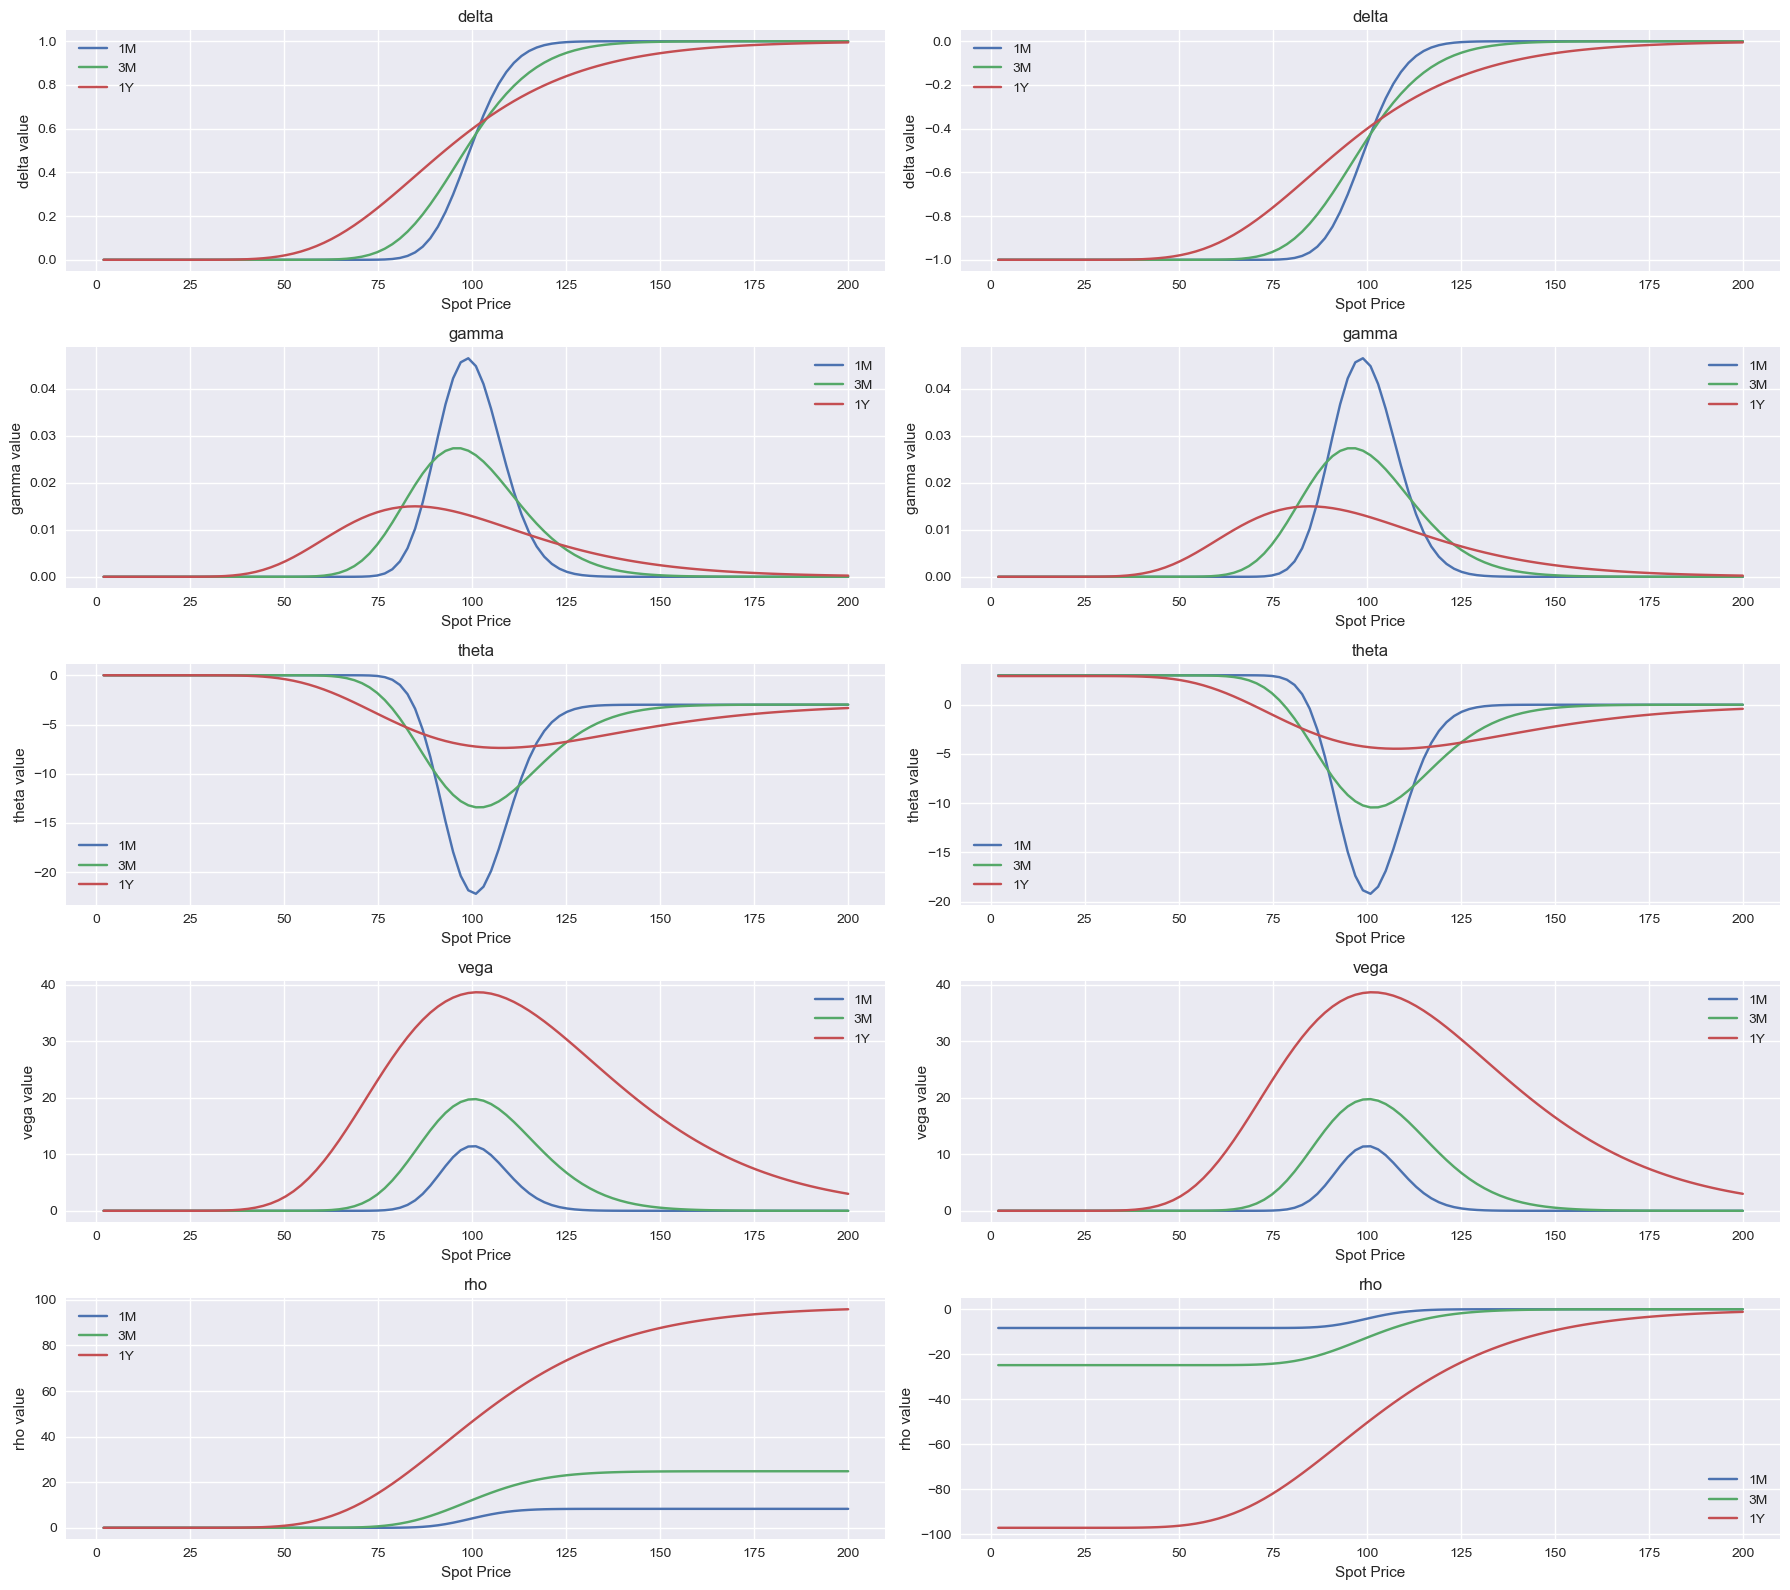

In [5]:
@Greeks_Analyser
def BlackScholes_Greeks(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS', cores:int=8) -> list[float]:
    
    def input_check(input_value=option_type):
        input_value = input_value.lower().replace(" ", "")
        input_map = {'call': 1, 'put': -1}
        if input_value in input_map:
            return input_map[input_value]
        else:
            raise ValueError("Invalid input. Please enter either 'call' or 'put'.")
    
    omega = input_check(option_type)
    
    d1 = (np.log(S0/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S0/K)+(r-sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    delta = omega*stats.norm.cdf(omega*d1)
    gamma = K*np.exp(-r*T)*stats.norm.pdf(d2)/((S0**2) * sigma * np.sqrt(T))
    theta = -0.5*S0*stats.norm.pdf(d1)*sigma/np.sqrt(T) - omega*r*K*np.exp(-r*T)*stats.norm.cdf(omega*d2)
    vega = S0*stats.norm.pdf(d1)*np.sqrt(T)
    rho = omega*K*T*np.exp(-r*T)*stats.norm.cdf(omega*d2)
    
    return np.array([delta, gamma, theta, vega, rho]).reshape(1,5)

res = BlackScholes_Greeks(S0=100, K=100, T=1, sigma=0.3, r=0.03, option_type="put", model="BS", cores=8)

## Monte Carlo

- Boost Performance for Monte Carlo
    - Joblib / Multiprocess for Boosting
    - Decorator of Monte Carlo
- Discritization
    - Euler-Maruyama Scheme
    - Milstein Scheme
- American Case: Longstaff-Schwartz Algorithm
- Variance Reduction
    - Anti Variant
    - Variable control
    - Importance Sampling
    - Quasi Monte Carlo

### Boost the performance of Monte Carlo

In this notebook we basically use 2 methods to boost the speed:

- joblib to realize parallel computing.
- numpy vectorize to use vectorize calculation.

Also there are many other methods, like Numba and Cython can be used to compile Python code into lower-level languages (such as C and C++) to enhance execution efficiency. But it's not in the content of this notebook.

### Decorator for Monte Carlo

Here we create an Decorater, which can analyse the vairance and confidence interval with the increase of interations.

In [100]:
import inspect

def MonteCarlo_Analyser(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, steps = 1000
        #        seed=42, cores = 8
        def payoff(S_T, K, option_type):
            return np.maximum(S_T - K, 0) if option_type == 'call' else np.maximum(K - S_T, 0)
        
        def confidence_interval(data, confidence=0.95):
            mean = np.mean(data)
            standard_error = stats.sem(data)
            degrees_of_freedom = len(data) - 1
            interval = stats.t.interval(confidence, degrees_of_freedom, mean, standard_error)
            return interval
        
        start_time = time.time()
        
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        
        S0 = bound_arguments.arguments.get('S0')
        K = bound_arguments.arguments.get('K')
        T = bound_arguments.arguments.get('T')
        r = bound_arguments.arguments.get('r')
        option_type = bound_arguments.arguments.get('option_type')
        model = bound_arguments.arguments.get('model')
        N = bound_arguments.arguments.get('N')
        seed = bound_arguments.arguments.get('seed')
        cores = bound_arguments.arguments.get('cores')
        steps= bound_arguments.arguments.get('steps')
        
        if model=='BS':
            sigma = bound_arguments.arguments.get('sigma')
        if model=='Heston':
            params = bound_arguments.arguments.get('params')
        
        step = N // 100   
        output = np.array(Parallel(n_jobs=cores)(delayed(func)(S0=S0,K=K,T=T,r=r,sigma=sigma,option_type=option_type,
            model=model, N=int(0.1*N/cores), seed=i*100, steps=steps, cores=cores) for i in range(cores*10)))
        output = output.flatten()
        res = 0
        
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        
        for idx, opt in enumerate(('call', 'put')):
            means, variances, confidence = [], [], []
 
            if model == "BS":
                true_value = BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt,
                                                                 model='BS')
            elif model == "Heston":
                true_value = Heston_CharacteristicFunction(S0=S0, K=K, T=T, r=r, params=params, 
                                                           option_type=opt, model='Heston')
            for i in range(step, N+1, step):
                data = np.exp(-r*T) * payoff(output[:i], K, opt)
                means.append(np.mean(data))
                variances.append(np.var(data, ddof=1))
                confidence.append(confidence_interval(data))
            err = round((np.abs(means[-1] - true_value) / true_value)*100, 2)
            x = np.arange(step, N+1, step)
            lower_bound = [interval[0] for interval in confidence]
            upper_bound = [interval[1] for interval in confidence]

            axs[idx].plot(x, means, label='Mean')
            axs[idx].fill_between(x, lower_bound, upper_bound, color='red', alpha=0.3, label='5% Confidence Interval')
            axs[idx].set_xlabel('Iteration')
            axs[idx].set_ylabel('Value')
            axs[idx].set_title('Monte Carlo Simulation with 5% Confidence Interval for {} option'.format(opt))
            axs[idx].axhline(y=true_value, color='g', linestyle='--', label='real value')
            axs[idx].legend(loc = 'best')
        
            print("The {} option price is: {}\n".format(opt, means[-1]),
                  "The true value is: {}\n".format(true_value),
                  "The {} option error is: {}% \n".format(opt, err))

            if option_type == opt:
                res = means[-1]
            
        plt.tight_layout()
        plt.show()
        print("The running time is {}s".format(time.time() - start_time))
        return res
    return wrapper

### Euler Scheme

#### Euler Scheme for Black-Scholes Model

- Normal case: $$ S_t = S_0 + rS_t \Delta t + \sigma S_0\sqrt{\Delta t}Z $$ 

- More precise: $$ log(S_{t})-log(S_{0}) = (r- \frac{\sigma^{2}}{2})t + \sigma \sqrt{t}z $$

- same as $$ S_{t} = S_{0}exp((r-\frac{1}{2}\sigma ^2)t+\sigma \sqrt{t} Z) $$




The call option price is: 13.183562993518775
 The true value is: 13.269676584660893
 The call option error is: 0.65% 

The put option price is: 3.7546146330478285
 The true value is: 3.753418388256833
 The put option error is: 0.03% 



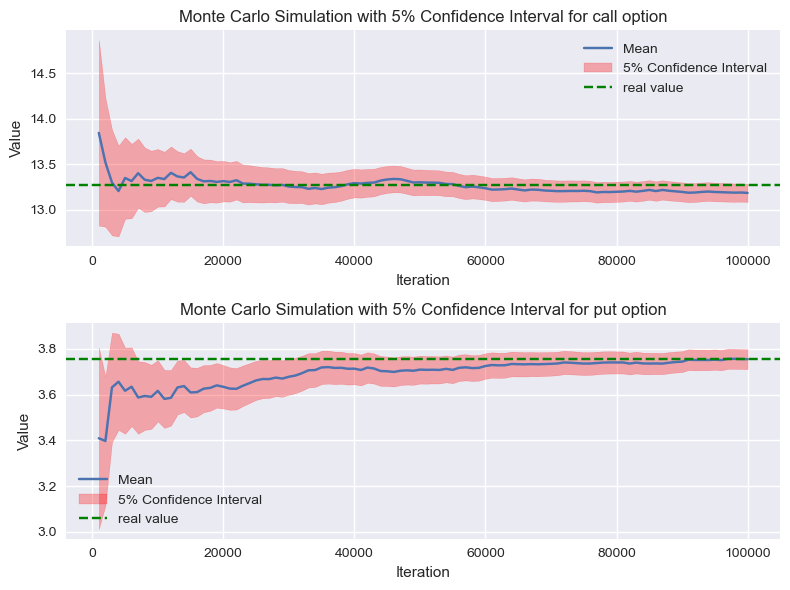

The running time is 0.8265159130096436s


In [101]:
@MonteCarlo_Analyser
def BlackScholes_MonteCarlo_Euler(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS', 
                                  N:int=100000, steps:int=1000, seed:int=42, cores:int=8)-> float:
    np.random.seed(seed)
    rvs = np.random.normal(size=(N, steps))
    dt = T / steps
    S_matrix = np.zeros((N, steps))
    S_matrix[:, 0] = S0
    
    for i in range(1, steps):
        S_matrix[:, i] = S_matrix[:, i-1] * (1 + r*dt + sigma*np.sqrt(dt)*rvs[:, i-1])
    return S_matrix[:, -1]

res = BlackScholes_MonteCarlo_Euler(S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', 
                                    model='BS', N=100000, steps = 1000, cores=8)


The call option price is: 13.240463008134787
 The true value is: 13.269676584660893
 The call option error is: 0.22% 

The put option price is: 3.7713732780005818
 The true value is: 3.753418388256833
 The put option error is: 0.48% 



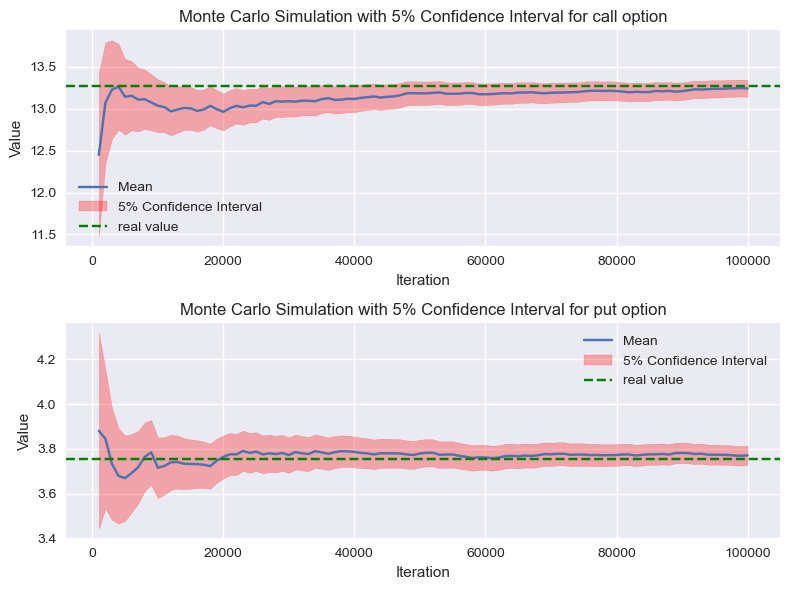

The running time is 0.25099706649780273s


In [102]:
@MonteCarlo_Analyser
def BlackScholes_MonteCarlo_Euler_logS(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS', 
                                       N:int=100000, seed:int=42, cores:int=8, steps:int=1) -> float:
    np.random.seed(seed)
    rvs = np.random.normal(size=N)
    S_T = S0 * np.exp((r - sigma**2/2)*T + sigma * np.sqrt(T) * rvs)
    return S_T

option_price = BlackScholes_MonteCarlo_Euler_logS(S0=100, K=100, T=1, sigma=0.2, r=0.1, N=100000, option_type='PUT',
                                         model='BS', seed='42', cores=8, steps=1)


#### Milstein Scheme Introduction

In the normal case: 
$$ dS_t = \mu(S_t)dt + \sigma(S_t)dW_t $$  
$$ S_{t+dt} = S_t + \int_{t}^{t+dt}\mu_s S_t ds + \int_{t}^{t+dt}\sigma_s S_tdWs $$  

In Milstein Scheme, we use ito's lemma to $\sigma(t)$ and $\mu(t)$.

$$ d\mu(S_t) = \mu_t'dS_t + \frac{1}{2}\mu_t''(dS_t)^2 $$ 
$$ = (\mu_t'\mu_t + \frac{1}{2}\mu_t''\sigma_t^2)dt + (\mu_t'\sigma_t)dW_t $$

$$ d\sigma(S_t) = \sigma_t'dS_t + \frac{1}{2}\sigma_t''(dS_t)^2 $$ 
$$ = (\sigma_t'\mu_t + \frac{1}{2}\sigma_t''\sigma_t^2)dt + (\sigma_t'\sigma_t)dW_t $$

$$ \mu_s = \mu_t + \int_{t}^{s}(\mu'_u\mu_u+\frac{1}{2}\mu_u''\sigma_u^2)du + \int_{t}^{s}(\mu_u'\sigma_u)dW_u $$ 
$$ \sigma_s = \sigma_t + \int_{t}^{s}(\sigma_u'\mu_u + \frac{1}{2}\sigma_u''\sigma_u^2)du + \int_{t}^{s}(\sigma_u'\sigma_u)dW_u $$

$$ S_{t+dt} = S_t + \int_{t}^{t+dt} (\mu_t + \int_{t}^{s} ((\mu_u'\mu_u + \frac{1}{2}\mu_u''\sigma_u^2)du + (\mu_u'\sigma_u)dW_u))ds)+ \int_{t}^{t+dt}(\sigma_t+\int_{t}^{s}(\sigma_u'\mu_u + \frac{1}{2}\sigma_u''\sigma_u^2)du + (\sigma_u'\sigma_u)dW_u))dW_s $$

Where we only care about $dW_tdW_t$, so finally: 
$$ S_{t+dt} = S_t + \mu_t\int_{t}^{t+dt}ds+\sigma_t\int_{t}^{t+dt}dW_s+\int_{t}^{t+dt}\int_{t}^{s}(\sigma_u'\sigma_u)dW_udW_s $$

$$ = S_t + \mu_t\int_{t}^{t+dt}ds + \sigma_t\int_{t}^{t+dt}dW_s + \sigma_t'\sigma\int_{t}^{t+dt}W_sdW_s $$

$$ = S_t + \mu_t\int_{t}^{t+dt}ds + \sigma_t\int_{t}^{t+dt}dW_s + \sigma_t'\sigma * \frac{1}{2}((\Delta W_{dt})^2 - dt) $$   

$$ =S_t + \mu(S_t)dt+\sigma(S_t)\sqrt{dt}Z+\frac{1}{2}\sigma(S_t)'\sigma(S_t)dt(Z^2-1) $$

#### Milstein scheme for Black-Scholes Models

$$ S_{t+dt}=S_t + rS_tdt+\sigma S_t\sqrt{dt}Z_1 + \frac{1}{2}\sigma_t^2dt(Z^2-1) $$

for log case:
$$ log(S_{t+dt}) = log(S_t) + (r- \frac{\sigma^2}{2})dt + \sigma \sqrt{dt} z $$

There is no $dS_t$ item, so it's equal to Euler-Maruyama scheme.That is why we use $d(log(S_t))$ more precise than $dS_t$ case.

- Complexity: $ O(N*steps)$, with the same complexity, increase N is better than step, cause Milstein already considered the second order.


The call option price is: 13.183560884258686
 The true value is: 13.269676584660893
 The call option error is: 0.65% 

The put option price is: 3.7546112747166793
 The true value is: 3.753418388256833
 The put option error is: 0.03% 



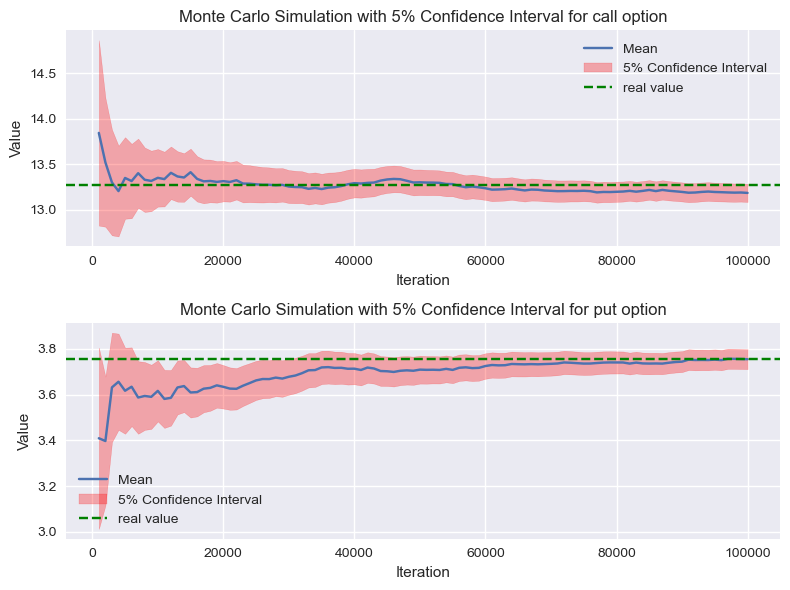

The running time is 1.8786911964416504s


In [103]:
@MonteCarlo_Analyser
def BlackScholes_MonteCarlo_Milstein(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS', 
                                     N:int=100000, steps:int=1000, seed:int=42, cores:int=8):
    np.random.seed(seed)
    rvs = np.random.normal(size=(N, steps))
    S_matrix = np.zeros((N, steps))
    S_matrix[:, 0] = S0
    dt = T / steps
    for i in range(1, steps):
        S_matrix[:, i] = S_matrix[:, i-1] + r*S_matrix[:, i-1]*dt + sigma*S_matrix[:, i-1]*np.sqrt(dt)*rvs[:, i-1]+ 0.5*(sigma**2)*dt*(rvs[:, i-1]**2 - 1)

    return S_matrix[:, -1]

res = BlackScholes_MonteCarlo_Milstein(S0=100, K=100, T=1, sigma=0.2, r=0.1, N=100000, option_type='call',
                                       model='BS', steps = 1000, cores=8)

### Longstaff-Schwartz Least Square Monte Carlo
- The first function assume we don't know future. Based on these the option price is even lower then European option due to early excution.

- The second assume that we know future information, so we could do the best decision for each time and the option price is close to European option.

In [104]:
def Longstaff(S0, K, T, r, sigma, payoff, N=1000, paths=10000, order=2):
    dT = T / (N-1)
    df = np.exp(-r * dT)
    np.set_printoptions(precision=8)
    
    S = np.zeros((paths, N+1))
    S[:,0] = np.array([S0]*paths)
    rvs = np.random.normal(size = (paths, N))

    for i in range(N):
        S[:, i+1] = S[:, i] * np.exp((r - sigma**2/2)*dT + 
                                     sigma * np.sqrt(dT) * rvs[:, i])

    IntrinsicValues = np.maximum(S - K, 0)
    OptionValues = IntrinsicValues.copy()

    for t in range(N-1, 0, -1):
        selected_path = IntrinsicValues[:, t] >0
        regression = np.polyfit(S[selected_path, t], IntrinsicValues[selected_path, t+1] * df, order)
        expect_HV = np.polyval(regression, S[selected_path, t])
        exercises = np.zeros(len(selected_path), dtype=bool)
        exercises[selected_path] = IntrinsicValues[selected_path, t] > expect_HV
        OptionValues[exercises, t] = IntrinsicValues[exercises, t]
        OptionValues[exercises, t+1] = -1
        OptionValues[~exercises, t] = OptionValues[~exercises, t+1] * df

    return np.mean(OptionValues[:, 1]) * df


In [105]:
def Longstaff2(S0, K, T, r, sigma, payoff, N=1000, paths=10000, order=2):
    dT = T / (N-1)
    df = np.exp(-r * dT)
    np.set_printoptions(precision=8)
    S = np.zeros((paths, N+1))
    S[:,0] = np.array([S0]*paths)
    rvs = np.random.normal(size = (paths, N))

    for i in range(N):
        S[:, i+1] = S[:, i] * np.exp((r - sigma**2/2)*dT + 
                                 sigma * np.sqrt(dT) * rvs[:, i])

    IntrinsicValues = np.maximum(S - K, 0)

    for t in range(N-1, 0, -1):
        selected_path = IntrinsicValues[:, t] >0
        regression = np.polyfit(S[selected_path, t], 
                                IntrinsicValues[selected_path, t+1] * df, order)
        expect_HV = np.polyval(regression, S[selected_path, t])
        exercises = np.zeros(len(selected_path), dtype=bool)
        exercises[selected_path] = IntrinsicValues[selected_path, t] > expect_HV
        IntrinsicValues[exercises, t+1] = -1
        IntrinsicValues[~exercises, t] = IntrinsicValues[~exercises, t+1] * df

    return np.mean(IntrinsicValues[:, 1]) * df

In [106]:
print(Longstaff(100, 100, 1, 0.1, 0.2, 'call', N=252, paths=10000, order=2))
print(Longstaff2(100, 100, 1, 0.1, 0.2, 'call', N=252, paths=10000, order=2))

6.675865973863015
13.316469702882685


### Techniques for variance reduction

- Antithetique Variant
- Variable Control
- Importance Sampling
- Quasi Monte Carlo

#### Antithetique variant
$$ Var[C_a] = \frac{1}{4}(Var[C_X]+Var[C_Y]+2Cov(C_X,C_Y) $$
$$ Var[C_a]=Var[\frac{1}{2}(h(X)+h(Y))] = \frac{\sigma^2}{2n}(1+\rho_{h(X),h(-X)}) $$
where:
$$ h = h_s+h_a $$
with: $$h_s(x)=\frac{1}{2}(h(x)+h(-x))$$ 
$$h_a(x)=\frac{1}{2}(h(x)-h(-x)) $$
- The more symmetry, the less effect.

The call option price is: 13.301394754147706
 The true value is: 13.269676584660893
 The call option error is: 0.24% 

The put option price is: 3.7672085188417648
 The true value is: 3.753418388256833
 The put option error is: 0.37% 



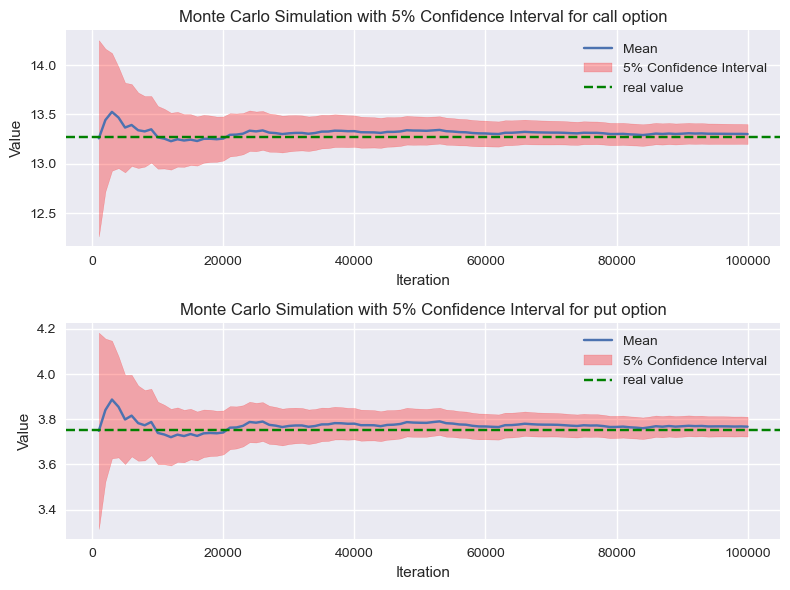

The running time is 1.2781620025634766s


In [107]:
@MonteCarlo_Analyser
def BlackScholes_AV(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS', 
                    N:int=100000, seed:int=42, cores:int=8, steps:int=1) -> float:
    np.random.seed(seed)
    rvs = np.random.normal(size=int(N/2))
    anti_rvs = -rvs
    
    stacked_rvs = np.vstack((rvs, anti_rvs))
    cross_concatenated_array = stacked_rvs.flatten('F') 
    
    S = S0 * np.exp((r - sigma**2/2)*T + sigma * np.sqrt(T) * cross_concatenated_array)
    return S

res = BlackScholes_AV(S0=100, K=100, T=1, sigma=0.2, r=0.1, N=100000, option_type='CALL')

#### Variable control

$$ E[h(X)] = C_c = E[h(X)+c(Z-E(Z))] $$
$$ Var[h(X)+c(Z-E(Z))] = Var[h(X)]+c^2Var[Z]+2c*Cov(h(X),Z) $$

From the equation we can conduct:
$$ c = -\frac{Cov(h(X),Z)}{V[Z]} $$
and $Var[C_c] = Var[C_X](1-\rho^2_{h(X),Z}) $

- The more correlation, the better

In [109]:
import inspect

def MonteCarlo_Analyser_CV(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, steps = 1000
        
        def confidence_interval(data, confidence=0.95):
            mean = np.mean(data)
            standard_error = stats.sem(data)
            degrees_of_freedom = len(data) - 1
            interval = stats.t.interval(confidence, degrees_of_freedom, mean, standard_error)
            return interval
        start_time = time.time()
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        
        S0 = bound_arguments.arguments.get('S0')
        K = bound_arguments.arguments.get('K')
        T = bound_arguments.arguments.get('T')
        sigma = bound_arguments.arguments.get('sigma')
        r = bound_arguments.arguments.get('r')
        option_type = bound_arguments.arguments.get('option_type')
        model = bound_arguments.arguments.get('model')
        N = bound_arguments.arguments.get('N')
        seed = bound_arguments.arguments.get('seed')
        cores = bound_arguments.arguments.get('cores')
        
        step = N // 100   
        
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        
        for idx, opt in enumerate(('call', 'put')):
            #output =  func(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS', N=N)
            output = np.array(Parallel(n_jobs=cores)
                              (delayed(func)(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS',
                                             N=int(0.1*N/cores), seed=i) for i in range(cores*10)))
            output = output.flatten()
            means, variances, confidence = [], [], []
            
            if model == "BS":
                true_value = BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, sigma=sigma, r=r, model=model, option_type=opt)
            elif model == "Heston":
                true_value = Heston_Formula(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type='opt')

            for i in range(step, N+1, step):
                data = output[:i]
                means.append(np.mean(data))
                variances.append(np.var(data, ddof=1))
                confidence.append(confidence_interval(data))
            err = round((np.abs(means[-1] - true_value) / true_value)*100, 2)
            x = np.arange(step, N+1, step)
            lower_bound = [interval[0] for interval in confidence]
            upper_bound = [interval[1] for interval in confidence]

            axs[idx].plot(x, means, label='Mean')
            axs[idx].fill_between(x, lower_bound, upper_bound, color='red', alpha=0.3, label='5% Confidence Interval')
            axs[idx].set_xlabel('Iteration')
            axs[idx].set_ylabel('Value')
            axs[idx].set_title('Monte Carlo Simulation with 5% Confidence Interval for {} option'.format(opt))
            axs[idx].axhline(y=true_value, color='g', linestyle='--', label='real value')
            axs[idx].legend(loc = 'best')
        
            print(" the {} option price is: {}\n".format(opt, means[-1]),"the true value is: {}\n".format(true_value), \
                 "the {} option error is: {}% \n".format(opt, err))
            
            if option_type == opt:
                res = means[-1]
            
        plt.tight_layout()
        plt.show()
        print("The running time is {}s".format(time.time() - start_time))    
        return res
    return wrapper

 the call option price is: 13.262696471476895
 the true value is: 13.269676584660893
 the call option error is: 0.05% 

 the put option price is: 3.758061337172524
 the true value is: 3.753418388256833
 the put option error is: 0.12% 



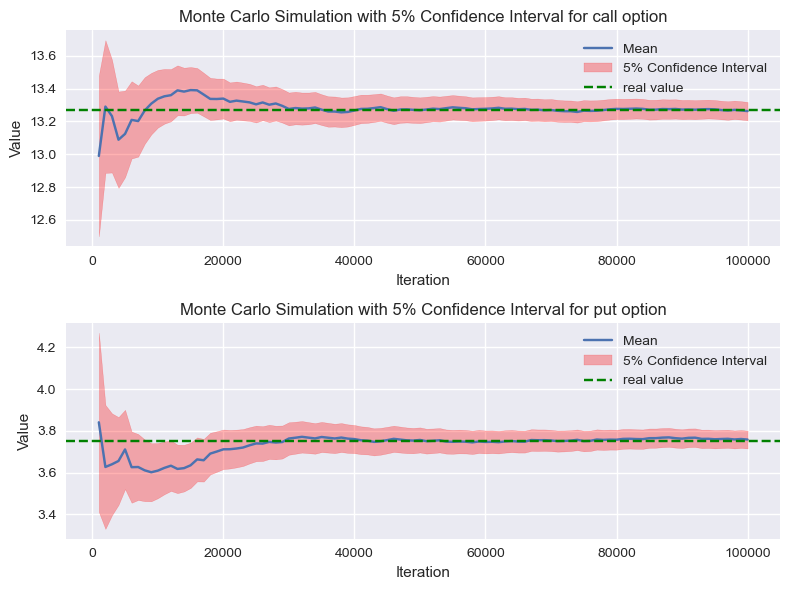

The running time is 0.8010311126708984s


In [110]:
@MonteCarlo_Analyser_CV
def BlackScholes_MonteCarlo_CV(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str='BS', 
                               N:int=1000000, seed:int=42, cores:int=8) -> float:
    np.random.seed(seed)
    rvs = np.random.normal(size=N)
    
    Z = np.maximum(50 * np.exp((0.01- 0.9**2/2)+0.9*rvs)-50, 0)*np.exp(-0.01)
    EZ = BlackScholes_ConditionalExpectation(S0=50, K=50, T=1, sigma=0.9, r=0.01, option_type=option_type, model="BS")
    
    S_T = S0 * np.exp((r - sigma**2/2)*T + sigma * np.sqrt(T) * rvs)
    if option_type=='call':
        payoff = np.maximum(S_T - K, 0) * np.exp(-r * T)
    elif option_type=='put':
        payoff = np.maximum(K - S_T, 0) * np.exp(-r * T)
    var_Z = np.var(Z)
    cor_h_Z = np.cov(Z, payoff)[1,0]
    c = -cor_h_Z / var_Z
    adjusted_payoff = payoff + c*(Z-EZ)

    return adjusted_payoff

res = BlackScholes_MonteCarlo_CV(S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', N=100000)

#### Importance sampling

In [114]:
import inspect

def MonteCarlo_Analyser_IS(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, steps = 1000
        
        def confidence_interval(data, confidence=0.95):
            mean = np.mean(data)
            standard_error = stats.sem(data)
            degrees_of_freedom = len(data) - 1
            interval = stats.t.interval(confidence, degrees_of_freedom, mean, standard_error)
            return interval
        
        start_time = time.time()
        
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        
        S0 = bound_arguments.arguments.get('S0')
        K = bound_arguments.arguments.get('K')
        T = bound_arguments.arguments.get('T')
        sigma = bound_arguments.arguments.get('sigma')
        r = bound_arguments.arguments.get('r')
        option_type = bound_arguments.arguments.get('option_type')
        model = bound_arguments.arguments.get('model')
        N = bound_arguments.arguments.get('N')
        seed = bound_arguments.arguments.get('seed')
        cores = bound_arguments.arguments.get('cores')
        
        step = N // 100   
        
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        
        for idx, opt in enumerate(('call', 'put')):
            #output =  func(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS', N=N)
            output = np.array(Parallel(n_jobs=cores)
                              (delayed(func)(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS',
                                             N=int(0.1*N/cores), seed=i) for i in range(cores*10)))
            output = output.flatten()
            means = []
            variances = []
            confidence = []
            
            if model == "BS":
                true_value = BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt)
            elif model == "Heston":
                true_value = Heston_Formula(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type='opt')

            for i in range(step, N+1, step):
                data = output[:i]
                means.append(np.mean(data))
                variances.append(np.var(data, ddof=1))
                confidence.append(confidence_interval(data))
            err = round((np.abs(means[-1] - true_value) / true_value)*100, 2)
            x = np.arange(step, N+1, step)
            lower_bound = [interval[0] for interval in confidence]
            upper_bound = [interval[1] for interval in confidence]

            axs[idx].plot(x, means, label='Mean')
            axs[idx].fill_between(x, lower_bound, upper_bound, color='red', alpha=0.3, label='5% Confidence Interval')
            axs[idx].set_xlabel('Iteration')
            axs[idx].set_ylabel('Value')
            axs[idx].set_title('Monte Carlo Importance Sampling Simulation with 5% Confidence Interval for {} option'.format(opt))
            axs[idx].axhline(y=true_value, color='g', linestyle='--', label='real value')
            axs[idx].legend(loc = 'best')
        
            print(" the {} option price is: {}\n".format(opt, means[-1]),"the true value is: {}\n".format(true_value), \
                 "the {} option error is: {}% \n".format(opt, err))
            
            if option_type == opt:
                res = means[-1]
            
        plt.tight_layout()
        plt.style.use('seaborn-dark-palette')
        plt.show()
        print("The running time is {}s".format(time.time() - start_time)) 
        return res
    return wrapper

The call option price is: 1.3009133113426026
 The true value is: 1.304869405342556
 The call option error is: 0.3% 

The put option price is: 28.01610056015234
 The true value is: 27.982107930376884
 The put option error is: 0.12% 



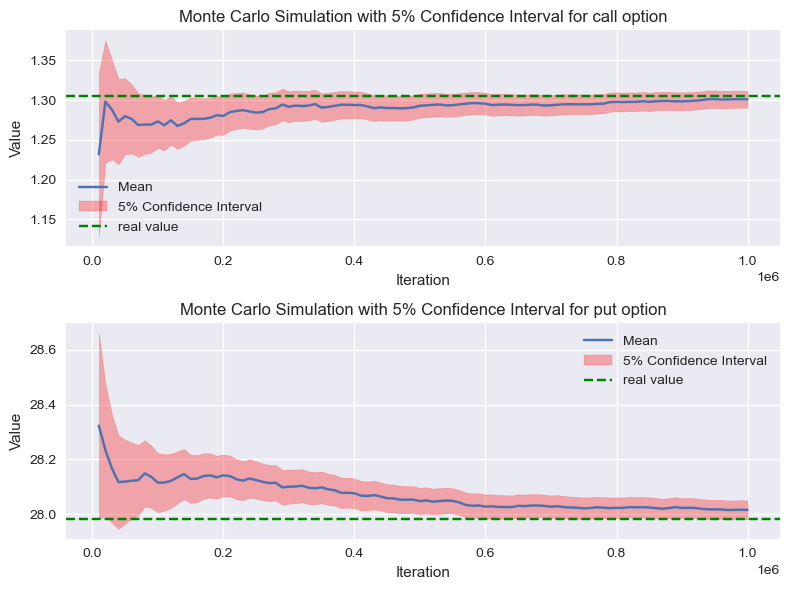

The running time is 0.5441808700561523s
 the call option price is: 1.304132948454254
 the true value is: 1.304869405342556
 the call option error is: 0.06% 

 the put option price is: 27.973586018565218
 the true value is: 27.982107930376884
 the put option error is: 0.03% 



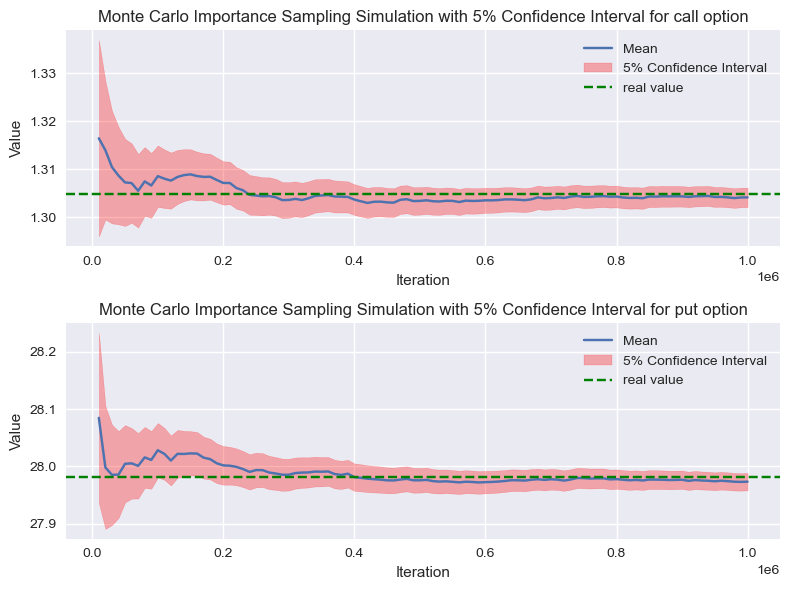

The running time is 1.3202180862426758s


In [115]:
@MonteCarlo_Analyser_IS
def BlackScholes_MonteCarlo_IS(S0:float, K:float, T:float, sigma:float, r:float, option_type:str='call', model:str='BS',
                               N:int=1000000, seed:int=42, cores:int=8) -> float:
    np.random.seed(seed)
    rvs = np.random.normal(size=N)
    
    mu0 = np.log(K/S0)
    p = stats.norm((r - sigma**2/2)*T, sigma * np.sqrt(T))
    q = lambda mu: stats.norm((r - (sigma**2)/2 + mu)*T, sigma * np.sqrt(T))


    def var(mu=mu0, option_type=option_type):
        log_S = (r - sigma**2/2 + mu)*T + sigma * np.sqrt(T) * rvs
        S_T = S0 * np.exp(log_S)
        if option_type == 'call':
            payoff = np.maximum((S_T - K),0) * p.pdf(log_S)/q(mu).pdf(log_S)
        elif option_type == 'put':
            payoff = np.maximum((K - S_T),0) * p.pdf(log_S)/q(mu).pdf(log_S)
        return np.var(payoff)

    mu = minimize(var, mu0).x
    log_S = (r - sigma**2/2 + mu)*T + sigma * np.sqrt(T) * rvs
    S_T = S0 * np.exp(log_S)
    
    if option_type== 'call':
        payoff = np.maximum(S_T - K, 0) * np.exp(-r * T)* p.pdf(log_S) / q(mu).pdf(log_S)
    elif option_type == 'put':
        payoff = np.maximum(K - S_T, 0) * np.exp(-r * T)* p.pdf(log_S) / q(mu).pdf(log_S)
    else:
        raise ValueError("option must be call or put")
        
    return payoff

res = BlackScholes_MonteCarlo_Euler_logS(S0=100, K=140, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, cores=8)
res_IS = BlackScholes_MonteCarlo_IS(S0=100, K=140, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, cores=8)


####  Quasi Monte Carlo

The call option price is: 13.276207940064003
 The true value is: 13.269676584660893
 The call option error is: 0.05% 

The put option price is: 3.7516432359091643
 The true value is: 3.753418388256833
 The put option error is: 0.05% 



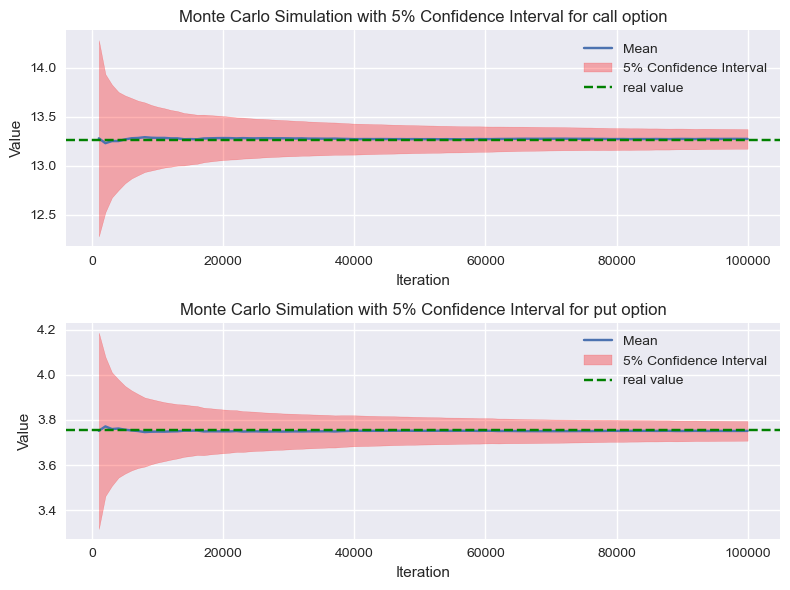

The running time is 0.2577488422393799s


In [116]:
from scipy.stats import qmc

@MonteCarlo_Analyser
def BlackScholes_MonteCarlo_QM(S0:float, K:float, T:float, sigma:float, r:float, option_type:str, model:str ='BS', 
                               N:int=100000, seed:int=42, cores:int=8, steps:int=1) -> float:
    np.random.seed(seed)
    rvs = norm.ppf(qmc.Halton(d=1, seed=seed).random(n=N)).flatten()
    S_T = S0 * np.exp((r - sigma**2/2)*T + sigma * np.sqrt(T) * rvs)
    
    return  S_T

res = BlackScholes_MonteCarlo_QM(S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=100000, cores=8)

##  Tree Model

### Binomial Tree for Option Pricing
**Criteria:**
$$u*d = 1$$
$$E(S_\Delta t) = S_0 * (pu+qd)$$
$$Var(S_\Delta t) = E(S^2_\Delta t) + E^2(S_\Delta t)$$

**Result:**
$$u = exp(σ\sqrt{Δt})$$
$$d = 1/u$$
$$p =\frac{e^{rΔt}-d}{u-d}$$
$$ q = 1 - p $$

In [120]:
import inspect

def BinomialTree_Analyser(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, steps = 1000
        start_time = time.time()
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        
        S0 = bound_arguments.arguments.get('S0')
        K = bound_arguments.arguments.get('K')
        T = bound_arguments.arguments.get('T')
        sigma = bound_arguments.arguments.get('sigma')
        r = bound_arguments.arguments.get('r')
        option_type = bound_arguments.arguments.get('option_type')
        model = bound_arguments.arguments.get('model')
        N = bound_arguments.arguments.get('N')
        cores = bound_arguments.arguments.get('cores')
        
        step = N // 100   
        
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        
        for idx, opt in enumerate(('call', 'put')):
            if model == "BS":
                true_value = BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt)
            elif model == "Heston":
                true_value = Heston_Formula(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type='opt')

            prices = []
            for i in range(step, N+1, step):
                prices.append(func(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS', N=i))  
            
            err = round((np.abs(prices[-1] - true_value) / true_value)*100, 2)
            
            x = np.arange(step, N+1, step)
            axs[idx].plot(x, prices, label='Prices of the option')
            axs[idx].set_xlabel('Iteration')
            axs[idx].set_ylabel('Value')
            axs[idx].set_title('Binomial {} option pricing'.format(opt))
            axs[idx].axhline(y=true_value, color='g', linestyle='--', label='real value')
            axs[idx].legend(loc = 'best')
        
            print(" the {} option price is: {}\n".format(opt, prices[-1]),"the true value is: {}\n".format(true_value), \
                 "the {} option error is: {}% \n".format(opt, err))
            
            if option_type == opt:
                res = prices[-1]
            
        plt.tight_layout()
        plt.show()
        print("The running time is {}s".format(time.time() - start_time)) 
        return res
    return wrapper

 the call option price is: 13.267588637032325
 the true value is: 13.269676584660893
 the call option error is: 0.02% 

 the put option price is: 3.7513304406239656
 the true value is: 3.753418388256833
 the put option error is: 0.06% 



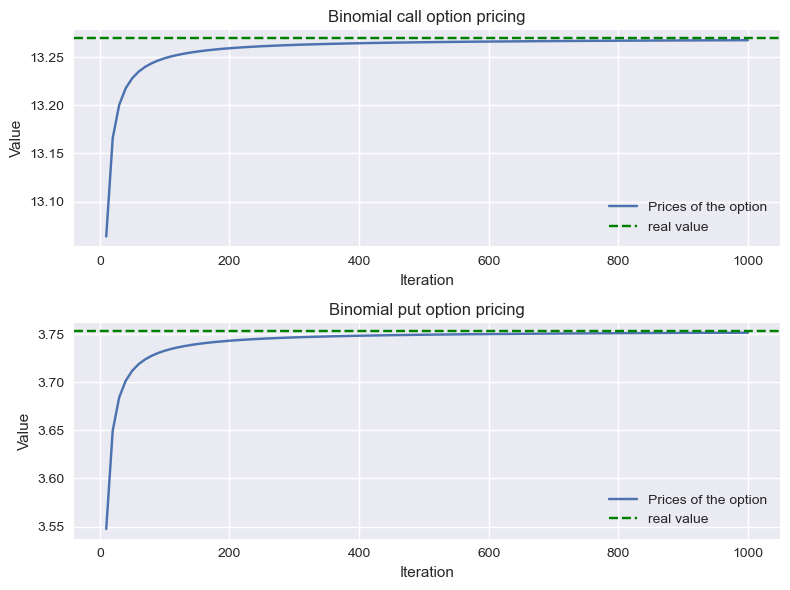

The running time is 0.6888236999511719s


In [121]:
@BinomialTree_Analyser
def BinomialTree(S0:float, K:float, T:float, r:float, sigma:float, option_type:str, 
                 model:str='BS', N:int=1000) -> float:
  dT = float(T) / N
  u = np.exp(sigma * np.sqrt(dT))
  d = 1.0 / u
  p = (np.exp(r*dT) - d) / (u - d)
  q = 1 - p

  S_T = np.array([(S0 * u**(N-j) * d**(j)) for j in range(N+1)])
  
  if option_type == "call":
    prices = np.maximum(S_T - K, 0)
  elif option_type == "put":
    prices = np.maximum(K - S_T, 0)

  for i in range(N-1, -1, -1):
    prices[:-1] = np.exp(-r * dT)*(p*prices[:-1] + q*prices[1:])

  return prices[0]

res = BinomialTree(S0=100, K=100, T=1, r=0.1, sigma=0.2, option_type='call', model='BS', N=1000)

### Binomial Tree for American Option Pricing

Here, the call value equals to the European Option, while the American put is higher than European Option, which meets the reality.

 the call option price is: 13.267588637032325
 the true value is: 13.269676584660893
 the call option error is: 0.02% 

 the put option price is: 4.815465694807183
 the true value is: 3.753418388256833
 the put option error is: 28.3% 



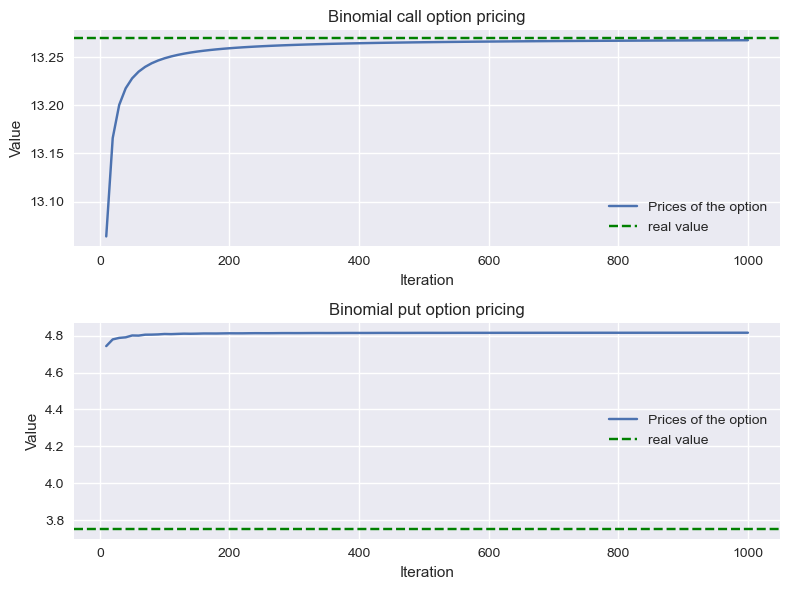

The running time is 1.0385501384735107s


In [119]:
@BinomialTree_Analyser
def BinomialTree_American(S0:float, K:float, T:float, r:float, sigma:float, option_type:str, 
                          model:str='BS', N:int=10000) -> float:
  dT = float(T) / N
  u = np.exp(sigma * np.sqrt(dT))
  d = 1.0 / u
  p = (np.exp(r*dT) - d) / (u - d)
  q = 1 - p

  S_T = np.array([(S0 * u**(N-j) * d**(j)) for j in range(N+1)])
  
  if option_type == "call":
    prices = np.maximum(S_T - K, 0)
  elif option_type == "put":
    prices = np.maximum(K - S_T, 0)

  for i in range(N-1, -1, -1):
    prices[:-1] = np.exp(-r * dT)*(p*prices[:-1] + q*prices[1:])
    S_T = S_T * d
    if option_type == "call":
      prices = np.maximum(prices, S_T - K)
    elif option_type == "put":
      prices = np.maximum(prices, K - S_T)
  return prices[0]

res = BinomialTree_American(S0=100, K=100, T=1, r=0.1, sigma=0.2, option_type='call', model='BS', N=1000)

## Finite Differential Method
FDE method is faster than Monte Carlo for pricing option. And easier for American option

Explicit scheme -> Easy to apply but not stable. The probability could be negative. \
Implicit scheme -> Solve the inverse of the matrix. Hard to calculate but stable.  \
Crank-Nicolson scheme -> 6 points, hard to calculate. Combine Explicit and Implicit. Best precise and unconditioned stablity.

In [122]:
import multiprocessing
import functools
from mpl_toolkits.mplot3d import axes3d
import inspect

def FiniteDifferential_Analyser(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, steps = 1000
        start_time = time.time()
        
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        
        S0 = bound_arguments.arguments.get('S0')
        K = bound_arguments.arguments.get('K')
        T = bound_arguments.arguments.get('T')
        sigma = bound_arguments.arguments.get('sigma')
        r = bound_arguments.arguments.get('r')
        option_type = bound_arguments.arguments.get('option_type')
        model = bound_arguments.arguments.get('model')
        N = bound_arguments.arguments.get('N')
        cores = bound_arguments.arguments.get('cores')
        
        step = N // 25
        triger = 0

        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))

        for idx, opt in enumerate(('call', 'put')):
            if model == "BS":
                true_value = BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt)
            elif model == "Heston":
                true_value = Heston_Formula(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type='opt')

            prices = []

            for i in range(step, N+1, step):
                prices.append(func(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS', N=i)[0])  
            
            matrix = func(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt, model='BS', N=N)[1]
            err = round((np.abs(prices[-1] - true_value) / true_value)*100, 2)
            
            x = np.arange(step, N+1, step)
            axs[idx].plot(x, prices, label='Prices of the option')
            axs[idx].set_xlabel('Iteration')
            axs[idx].set_ylabel('Value')
            axs[idx].set_title('Finite Difference Method {} option pricing'.format(opt))
            axs[idx].axhline(y=true_value, color='g', linestyle='--', label='real value')
            axs[idx].legend(loc = 'best')

            print(" the {} option price is: {}\n".format(opt, prices[-1]),"the true value is: {}\n".format(true_value), \
                 "the {} option error is: {}% \n".format(opt, err))

            if option_type == opt:
                res = prices[-1]

            triger+=1
            
        plt.tight_layout()
        plt.show()
        print("The running time is {}s".format(time.time() - start_time)) 
        return res
    return wrapper

### Explicit Euler Method



$$ f_{i,j-1}=a_i*f_{i+1,j}+b_i*f_{i,j}+c_i*f_{i-1,j} $$
$$ a = \frac{1}{2}\Delta t(\sigma^2i^2+ri) $$
$$ b = 1-\Delta t(\sigma^2i^2+r) $$
$$ c = \frac{1}{2}\Delta t(\sigma^2i^2-ri) $$ 

- Stable condition: $0<\frac{dt}{dS^2}<\frac{1}{2}$
- The accuracy for Explicit Euler is dt

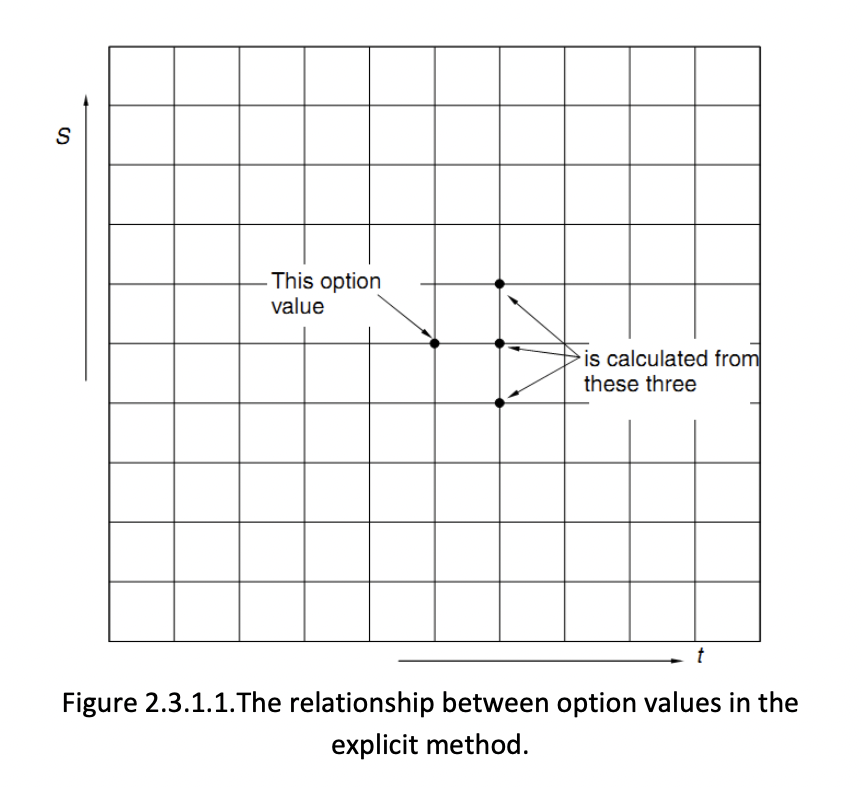

In [123]:
Image(filename = '/Users/xiaoyanwang/Downloads/Explicit.png', width=200, height=200)

 the call option price is: 13.228037109474467
 the true value is: 13.269676584660893
 the call option error is: 0.31% 

 the put option price is: 3.7117336709714452
 the true value is: 3.753418388256833
 the put option error is: 1.11% 



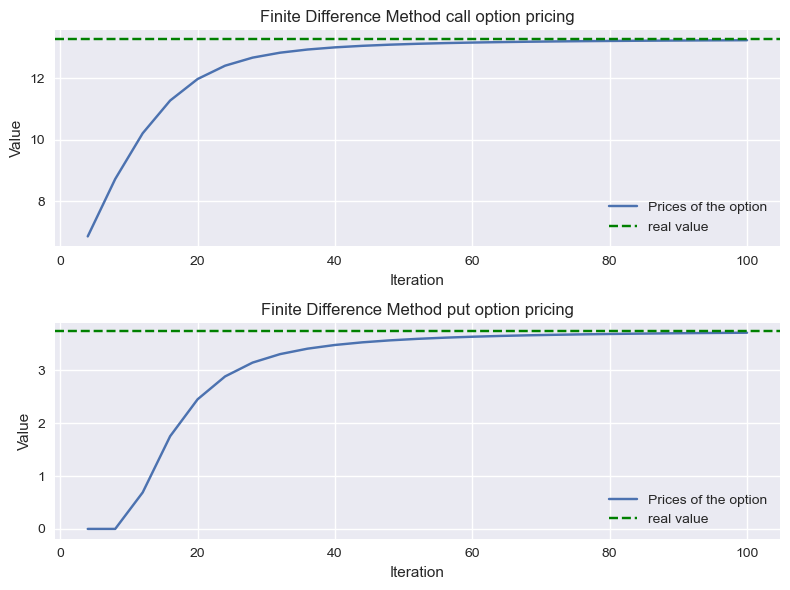

The running time is 42.731852769851685s


In [129]:
@FiniteDifferential_Analyser
def BlackScholes_ExplicitEuler(S0:float, K:float, r:float, sigma:float, T:float, N:int=100,
                                 option_type:str="call", model:str='BS', cores:int=8) -> tuple[float, np.ndarray]:
    
    Matrix = np.zeros((N+1, (N**2)+1))
    S_max = 4 * K
    dS = S_max / N
    dt = T / (N**2)
    if option_type=='call':
        Matrix[0, :] = 0
        Matrix[N, :] = S_max - K
        Matrix[:, -1] = np.maximum(np.arange(N+1)*dS - K, 0)
    elif option_type=='put':
        Matrix[0, :] = K
        Matrix[N, :] = 0
        Matrix[:, -1] = np.maximum(K - np.arange(N+1)*dS, 0)
    
    for j in range(Matrix.shape[1]-2, -1, -1):
        for i in range(Matrix.shape[0]-2, 0, -1):
            a = dt * ((sigma**2) * (i**2) + r*i)/2
            b = 1 - dt*((sigma**2)*(i**2) + r)
            c = dt * ((sigma**2) * (i**2) - r*i)/2
            Matrix[i,j]= np.maximum(a*Matrix[i+1,j+1]+b*Matrix[i,j+1]+c*Matrix[i-1,j+1], 0)
        
    return Matrix[N//4,0], Matrix

res = BlackScholes_ExplicitEuler(S0=100, K=100, r=0.1, sigma=0.2, T=1, N=100)

The result seems okay but less precise.

### Implicit Euler Method

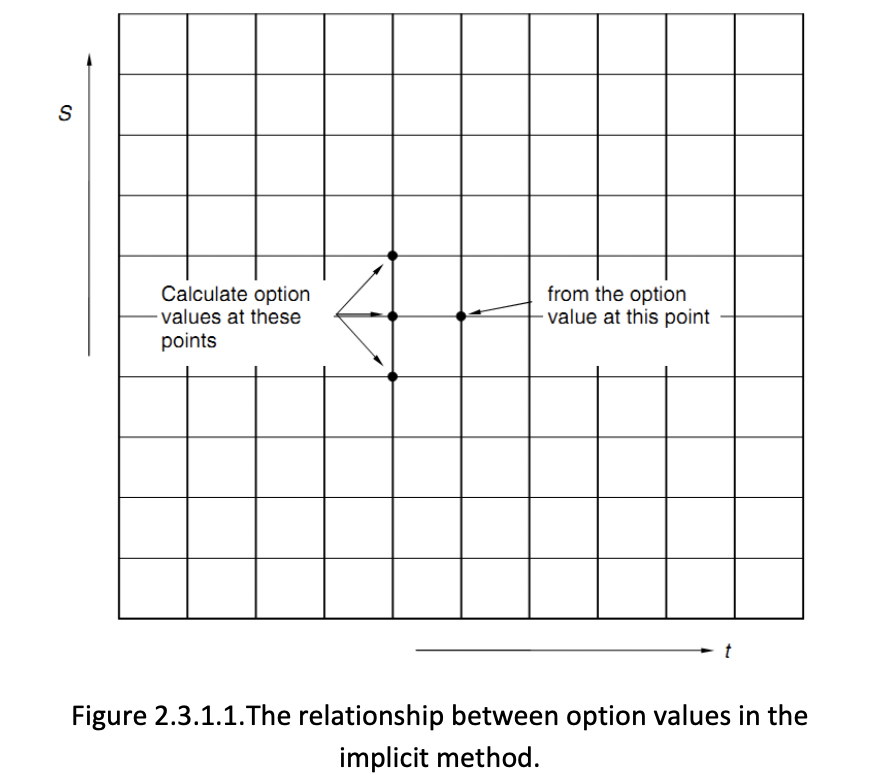

In [130]:
Image(filename = '/Users/xiaoyanwang/Downloads/Implicit.png', width=200, height=200)

 the call option price is: 13.268165879459048
 the true value is: 13.269676584660893
 the call option error is: 0.01% 

 the put option price is: 3.752360093245608
 the true value is: 3.753418388256833
 the put option error is: 0.03% 



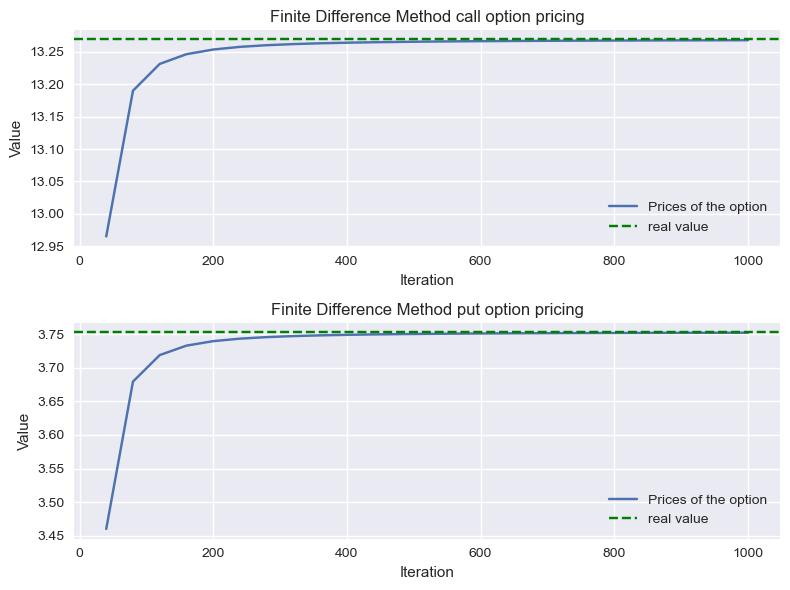

The running time is 2.3782429695129395s


In [134]:
@FiniteDifferential_Analyser
def BlackScholes_ImplicitEuler(S0:float, K:float, r:float, sigma:float, T:float, N:int=100,
                              option_type:str="call", model:str='BS', cores:int=8) -> tuple[float, np.ndarray]:
    Matrix = np.zeros((N+1, N+1))
    S_max = 4 * K
    dS = S_max / N
    dt = T / N
    
    if option_type=='call':
        Matrix[0, :] = 0
        Matrix[N, :] = S_max - K
        Matrix[:, -1] = np.maximum(np.arange(N+1)*dS - K, 0)
    elif option_type=='put':
        Matrix[0, :] = K
        Matrix[N, :] = 0
        Matrix[:, -1] = np.maximum(K - np.arange(N+1)*dS, 0)

    CoefficientMatrix = np.matrix(np.zeros((N+1, N+1)))
    CoefficientMatrix[0, 0] = 1 + dt*((sigma**2)*(N**2) + r)
    CoefficientMatrix[0, 1] = dt * (r*N - (sigma**2) * (N**2))/2
    CoefficientMatrix[N, N-1] = dt * (sigma**2)/2
    CoefficientMatrix[N, N] = 1 - dt*((sigma**2) + r)
    
    for i in range(1, N):
        CoefficientMatrix[i, i-1] = -dt * ((sigma**2) * ((N-i)**2) + r*(N-i))/2
        CoefficientMatrix[i, i] = 1 + dt*((sigma**2)*((N-i)**2) + r)
        CoefficientMatrix[i, i+1] = dt * (r*(N-i)-(sigma**2) * ((N-i)**2) )/2

    Inverse_Matrix = CoefficientMatrix.I
    
    for i in range(N-1, -1, -1):
        F1 = Matrix[:,i+1][::-1]
        F0 = np.dot(Inverse_Matrix, F1)
        Matrix[1:N,i] = F0[0, 1:N][:, ::-1]
        
    return Matrix[N//4,0], Matrix

res = BlackScholes_ImplicitEuler(S0=100, K=100, r=0.1, sigma=0.2, T=1, N=1000)

### Crank-Nicolson

- The combination of Explicit and Implicit. The sum of the two result. And the accuracy is $(dt)^2$

$$ \frac{1}{2}Explicit + \frac{1}{2}Implicit $$
$$ -a_if_{i+1,j-1}+(1-b_i)f_{i,j-1}-c_if_{i-1,j-1} = a_if_{i+1,j}+(1+b_i)f_{i,j}+c_if_{i-1,j} $$


$$ a_i = \frac{1}{4}\Delta t(\sigma ^2 i^2 + ri) $$
$$ b_i = -\frac{1}{2}\Delta t (\sigma^2i^2+r) $$
$$ c_i = \frac{1}{4}\Delta t(\sigma ^2 i^2 - ri) $$

$$ M_1 f_{j-1} = M_2 f_j $$

 the call option price is: 13.269029434391406
 the true value is: 13.269676584660893
 the call option error is: 0.0% 

 the put option price is: 3.7527712304533285
 the true value is: 3.753418388256833
 the put option error is: 0.02% 



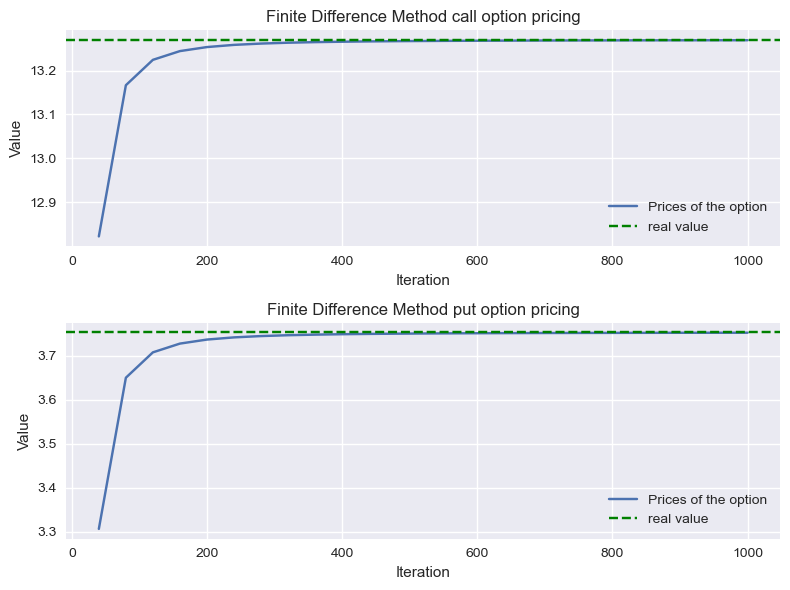

The running time is 372.8024079799652s


In [133]:
@FiniteDifferential_Analyser
def BlackScholes_CrankNicolson(S0:float, K:float, r:float, sigma:float, T:float, N:int=1000
                              , model:str='BS', option_type:str='call', cores:int=8) -> tuple[float, np.ndarray]:
    Matrix = np.zeros((N+1, N+1))
    S_max = 5 * K
    dS = S_max / N
    dt = T / N
        
    if option_type=='call':
        Matrix[0, :] = 0
        Matrix[N, :] = S_max - K
        Matrix[:, -1] = np.maximum(np.arange(N+1)*dS - K, 0)
    
    elif option_type=='put':
        Matrix[0, :] = K
        Matrix[N, :] = 0
        Matrix[:, -1] = np.maximum(K - np.arange(N+1)*dS, 0)
    
    CoefficientMatrix1 = np.matrix(np.zeros((N+1, N+1)))
    CoefficientMatrix2 = np.matrix(np.zeros((N+1, N+1)))
    
    CoefficientMatrix1[0, 0] = 1 + dt*((sigma**2)*(N**2) + r)/2
    CoefficientMatrix1[0, 1] = -(dt * ((sigma**2) * (N**2) - r*N)/4)
    CoefficientMatrix1[N, N-1] = -(dt * (sigma**2)/4)
    CoefficientMatrix1[N, N] = 1 + dt*((sigma**2)* + r)/2
        
    CoefficientMatrix2[0, 0] = 1 - dt*((sigma**2)*(N**2) + r)/2
    CoefficientMatrix2[0, 1] = dt * ((sigma**2) * (N**2) - r*N)/4
    CoefficientMatrix2[N, N-1] = dt * (sigma**2)/4
    CoefficientMatrix2[N, N] = 1 - dt*((sigma**2)* + r)/2
    
    for i in range(1, N):
        a = dt * ((sigma**2) * ((N-i)**2) + r*(N-i))/4
        b = -dt*((sigma**2)*((N-i)**2) + r)/2
        c = dt * ((sigma**2) * ((N-i)**2) - r*(N-i))/4
        CoefficientMatrix1[i, i-1] = -a
        CoefficientMatrix1[i, i] = 1-b
        CoefficientMatrix1[i, i+1] = -c
        CoefficientMatrix2[i, i-1] = a
        CoefficientMatrix2[i, i] = 1+b
        CoefficientMatrix2[i, i+1] = c

    Inverse_CoefficientMatrix1 = CoefficientMatrix1.I

    for i in range(N-1, -1, -1):
        F1 = Matrix[:,i+1][::-1]
        F0 = np.dot(np.dot(Inverse_CoefficientMatrix1, CoefficientMatrix2), F1)
        Matrix[1:N,i] = F0[0, 1:N][:, ::-1]
    
    return Matrix[N//5,0], Matrix

res = BlackScholes_CrankNicolson(S0=100, K=100, r=0.1, sigma=0.2, T=1, N=1000)

## Implied Volatility

In [10]:
from scipy.stats import norm

def ImpliedVolatility_Calculator(date_list, options_data, ticker='AAPL', cores=8, poly=4, panalty=0.3, current_price=100, 
                             lr_init=1, sigma_init=3, tol=0.0001):
    def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, q=0.1, option_type="call", model="BS"):
        omega = np.where(option_type == 'call', 1, -1)
        d1 = (np.log(S0/K)+(r-q+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = (np.log(S0/K)+(r-q-sigma**2/2)*T) / (sigma*np.sqrt(T))
        return S0*np.exp(-q*T)*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

    def get_risk_free_rate():
        fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
        fred = Fred(api_key=fred_api_key)
        return fred.get_series('TB3MS')[-1] / 100
    
    def error_function(S0, K, T, r, sigma, market_price, option_type, q=0):
        return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, option_type=option_type) - market_price

    def vega(S0, K, T, r, sigma, q=0):
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)
    
    def adjust_sigma(sigma, loss):
        return np.where(loss>0, sigma*0.5, sigma*2)
    
    def minimum_payoff(S0, K, T, r, option_type):
        return np.where(option_type == 'call', S0 - K * np.exp(-T * r), K * np.exp(-T * r) - S0)

    def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr_init, sigma_init, tol=0.00001):
        #minimum_value = np.where(option_type=='call', S0-K*np.exp(-r*T), K*np.exp(-r*T)-S0)
        sigma1 = sigma2 = sigma_init
        loss1 = loss2 = error_function(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price)
        lr = lr_init
        
        error_function_vectorized = np.vectorize(error_function)
        adjust_sigma_vectorized = np.vectorize(adjust_sigma)

        while np.any(np.abs(loss2) >= tol):
            lr = np.where(np.abs(loss1)<tol, 0, lr)
            sigma1 = sigma2
            loss1 = np.where(lr!=0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price), 0)
            vega1 = np.where(lr!=0, vega(S0=S0, K=K, T=T, r=r, sigma=sigma1, q=0), 0)
            sigma2 = np.where(lr!=0, sigma1 - lr*loss1/vega1, 0)
            loss2 = np.where(lr!=0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma2, option_type=option_type, market_price=market_price), 0)
            sigma1 = np.where(loss1 * loss2 >= 0, sigma2, sigma1)
            lr = np.where(loss1 * loss2 < 0, np.where(lr >0.01, lr/3, lr), lr)
            sigma2 = np.where(loss1 * loss2 < 0, np.where(lr<=0.01, adjust_sigma_vectorized(sigma1, loss1),sigma1),sigma1)                 
            loss2 = np.where(lr!=0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma2, option_type=option_type, market_price=market_price), 0)
            
        return sigma2

    BlackScholes_Implied_Vol = np.vectorize(BlackScholes_Implied_Vol)

    current_stock_price = current_price
    today = datetime.date.today()
    risk_free_rate = get_risk_free_rate()

    options = []
    for i in range(len(date_list)):
        options_data[i]['Maturity'] = (datetime.datetime.strptime(date_list[i],"%Y-%m-%d").date() - today).days/365
        options_data[i]['option_type'] = options_data[i]['contractSymbol'].apply(lambda x:'call' if x[-9]=='C' else 'put')
        options_data[i]['lr'] = lr_init
        options_data[i]['sigma_init'] = sigma_init
        options_data[i]['mid'] = np.maximum((options_data[i]['bid']+options_data[i]['ask'])/2, options_data[i]['lastPrice'])
        options_data[i]['minimum'] = np.where(options_data[i]['option_type']=='call', current_stock_price-options_data[i]['strike']*
                                      np.exp(-risk_free_rate*options_data[i]['Maturity']), options_data[i]['strike']*
                                      np.exp(-risk_free_rate*options_data[i]['Maturity']) - current_stock_price)
        options_data[i] = options_data[i][options_data[i]['minimum'] < options_data[i]['mid']]
        options_data[i]['Implied_Vol'] = BlackScholes_Implied_Vol(S0 = current_stock_price, K = options_data[i]['strike'], T = options_data[i]['Maturity'], sigma_init= options_data[i]['sigma_init'],
                                                            r = risk_free_rate, q=0, market_price = options_data[i]['mid'], option_type = options_data[i]['option_type'], 
                                                            lr_init=options_data[i]['lr'], tol = tol)
        options_data[i].loc[(options_data[i]['Implied_Vol'] > 5) | (options_data[i]['Implied_Vol'] < -5), 'Implied_Vol'] = 0
        options.append(options_data[i])

    return options


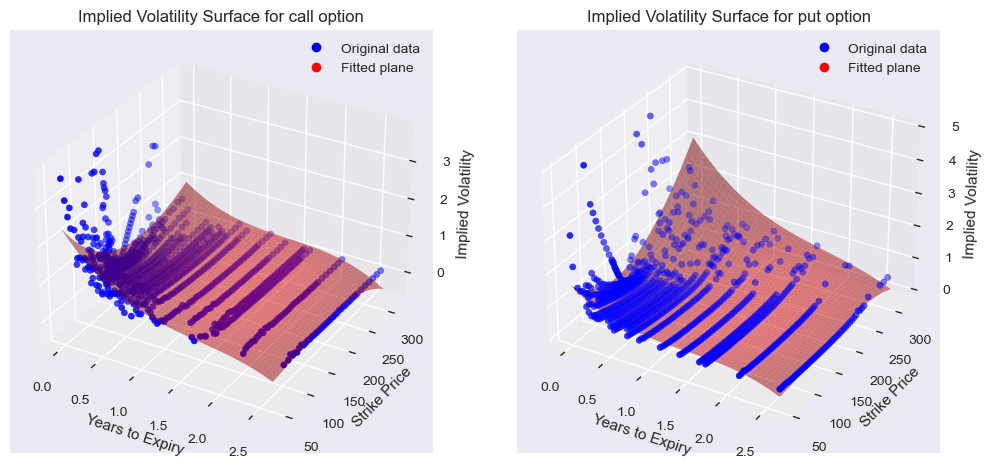

finished in 38.128498792648315 seconds.


In [16]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from matplotlib.lines import Line2D

def Implied_Volatility_Surface(ticker, cores=4, poly=4, penalty=0.3):
    def split_array(array, num_parts):
        result = []
        size_per_part = len(array) // num_parts
        remainder = len(array) % num_parts
        start = 0
        for i in range(num_parts):
            end = start + size_per_part
            if i < remainder:
                end += 1
            result.append(array[start:end])
            start = end
        return result

    t = time.time()

    stock = yf.Ticker(ticker)
    stock_info = stock.info
    current_stock_price = stock_info['regularMarketPrice']
    date_lists = stock.options

    options_data = []
    for date in date_lists:
        option_data = stock.option_chain(date)
        call_data = option_data.calls
        put_data = option_data.puts
        options_data.append(pd.concat([call_data, put_data]))

    date_lists = split_array(array = date_lists, num_parts=cores)
    option_lists = split_array(array = options_data, num_parts=cores)

    output = np.array(Parallel(n_jobs=cores)(delayed(ImpliedVolatility_Calculator)(ticker=ticker, options_data=option_lists[i],
                  date_list=date_lists[i], current_price=current_stock_price,lr_init=1, sigma_init=2) for i in range(cores)))

    opt_dict = {'call':0, 'put':1}

    plt.style.use('default')
    plt.style.use('seaborn')
    fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

    for opt in ('call', 'put'):
        train_x_list = []
        train_y_list = []
        for i in range(0, len(output)):
            for j in range(len(output[i])):
                temp = output[i][j][output[i][j]['option_type'] == opt]
                temp = temp[temp['Implied_Vol'] != 0]
                temp = temp.dropna(subset=['Implied_Vol'])
                train_x = list(zip(temp['Maturity'].values.tolist(), 
                                      temp['strike'].values.tolist()))
                train_x = [list(item) for item in train_x]
                train_y = temp['Implied_Vol'].values.tolist()
                train_x_list += train_x
                train_y_list += train_y

        train_x_list = np.array(train_x_list)

        model = make_pipeline(PolynomialFeatures(poly), Ridge(alpha=penalty))
        model.fit(train_x_list, train_y_list)

        ax[opt_dict[opt]].scatter(train_x_list[:, 0], train_x_list[:, 1], train_y_list, c='b', marker='o', label='Original data')

        x0_range = np.linspace(train_x_list[:, 0].min(), train_x_list[:, 0].max(), num=100)
        x1_range = np.linspace(train_x_list[:, 1].min(), train_x_list[:, 1].max(), num=100)
        x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)

        X_grid = np.hstack([x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)])
        y_grid_pred = model.predict(X_grid).reshape(x0_grid.shape)
        surface = ax[opt_dict[opt]].plot_surface(x0_grid, x1_grid, y_grid_pred, color='r', alpha=0.5)
        ax[opt_dict[opt]].set_xlabel('Years to Expiry')
        ax[opt_dict[opt]].set_ylabel('Strike Price')
        ax[opt_dict[opt]].set_zlabel('Implied Volatility')
        ax[opt_dict[opt]].set_title('Implied Volatility Surface for {} option'.format(opt))
        original_data_proxy = Line2D([0], [0], linestyle='none', c='b', marker='o')
        fitted_plane_proxy = Line2D([0], [0], linestyle='none', c='r', marker='o')
        ax[opt_dict[opt]].legend([original_data_proxy, fitted_plane_proxy], 
                                 ['Original data', 'Fitted plane'], numpoints=1)

    plt.show()
    print('finished in {} seconds.'.format(time.time()-t))
    return model, output

ticker='AAPL'
model = Implied_Volatility_Surface(ticker=ticker, cores=4, poly=3, penalty=0.3)



In [290]:
model[1][7][0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,Maturity,option_type,lr,sigma_init,mid,minimum,Implied_Vol
4,AAPL250620C00070000,2023-04-21 17:08:51+00:00,70.00,102.00,0.00,0.00,0.00,0.00,11.00,261,...,True,REGULAR,USD,2.15,call,1,2,102.00,100.49,0.41
5,AAPL250620C00075000,2023-04-25 14:33:47+00:00,75.00,96.00,0.00,0.00,0.00,0.00,325.00,273,...,True,REGULAR,USD,2.15,call,1,2,96.00,95.97,0.21
6,AAPL250620C00080000,2023-04-25 14:39:39+00:00,80.00,92.10,0.00,0.00,0.00,0.00,321.00,262,...,True,REGULAR,USD,2.15,call,1,2,92.10,91.46,0.31
7,AAPL250620C00085000,2023-04-25 14:29:59+00:00,85.00,88.18,0.00,0.00,0.00,0.00,2.00,157,...,True,REGULAR,USD,2.15,call,1,2,88.18,86.94,0.32
8,AAPL250620C00090000,2023-04-25 14:41:14+00:00,90.00,84.00,0.00,0.00,0.00,0.00,320.00,366,...,True,REGULAR,USD,2.15,call,1,2,84.00,82.42,0.32
9,AAPL250620C00095000,2023-04-25 14:41:13+00:00,95.00,80.15,0.00,0.00,0.00,0.00,1096.00,3893,...,True,REGULAR,USD,2.15,call,1,2,80.15,77.90,0.33
10,AAPL250620C00100000,2023-04-21 17:20:30+00:00,100.00,76.00,0.00,0.00,0.00,0.00,4.00,227,...,True,REGULAR,USD,2.15,call,1,2,76.00,73.38,0.32
11,AAPL250620C00105000,2023-04-21 19:46:00+00:00,105.00,72.30,0.00,0.00,0.00,0.00,1.00,149,...,True,REGULAR,USD,2.15,call,1,2,72.30,68.86,0.32
12,AAPL250620C00110000,2023-03-14 19:03:41+00:00,110.00,57.38,68.00,69.75,0.00,0.00,1.00,122,...,True,REGULAR,USD,2.15,call,1,2,68.88,64.34,0.32
13,AAPL250620C00115000,2023-04-20 17:53:39+00:00,115.00,67.40,0.00,0.00,0.00,0.00,1.00,588,...,True,REGULAR,USD,2.15,call,1,2,67.40,59.82,0.37


## Dupire Formula and Local Volatility

### Kolmogorov Backward Equation

Assume that:
$$ dX_t = \mu(X_t)dt + \sigma(X_t)dW_t$$
$$ V(t,X_t) = E^{t,X_t}[h(X_T)] = \int^{\infty}_{K}(X_T - K)p(t,X_t,T, X_T)dX_T $$
$$ V_t = \frac{\partial V}{\partial t}=\int^{\infty}_{K}(X_T - K)\frac{\partial p(t,X_t ,T, X_T)}{\partial t}dX_T $$
$$V_x = \frac{\partial V}{\partial X_t}=\int^{\infty}_{K}(X_T - K)\frac{\partial p(t,X_t,T, X_T)}{\partial X_t}dX_T $$
$$V_xx\frac{\partial^2 V}{\partial X^2_t}=\int^{\infty}_{K}(X_T - K)\frac{\partial ^2 p(t,X_t,T, X_T)}{\partial X^2_t }dX_T$$

Based on Black-Scholes Equation:
$$V_t + \mu(X_t)V_x + \frac{1}{2}\sigma^2(X_t)V_{xx} = 0 $$
Get:
$$ \frac{\partial(t,X_t, T, X_T)}{\partial t} + \mu(X_t)\frac{\partial(t, X_t, T, X_T)}{\partial X_t} + \frac{1}{2}\sigma^2(X_t)\frac{\partial^2(t,X_t, T, X_T)}{\partial X_t^2}= 0$$

### Kolmogorov Forward Equation (Fokker Planck)
$$ V(T,X_T) - V(t, X_t) = \int^{T}_{t} \frac{\partial V}{\partial u}+\mu(X_u)\frac{\partial V}{\partial X_u} + \sigma^2(X_u)\frac{\partial^2 V}{\partial X_u ^2} du$$

Take the expectation:
$$    E[V(T,X_T) - V(t, X_t)] = \int_R\int^{T}_{t} (\frac{\partial V}{\partial u}+\mu(X_u)\frac{\partial V}{\partial X_u} + \frac{1}{2}\sigma^2(X_u)\frac{\partial^2 V}{\partial X_u ^2} ) p(t,X_t, u, X_u)du dX_u$$

Calculate these 3 items separately.
$$ I_1 = \int_{R}\int^{T}_{t}p(t, X_t, u, X_u)\frac{\partial V}{\partial u}dtdX_u = -\int_{R}\int^{T}_{t}V(u,X_u)\frac{\partial p}{\partial u}dudX_u$$

$$ I_2 = \int_{R}\int^{T}_{t}p(t, X_t, u, X_u)\mu(X_u)\frac{\partial V}{\partial X_u}dtdX_u = -\int_{R}\int^{T}_{t}V(u,X_u)\frac{\partial p \mu(X_u)}{\partial X_u}dudX_u$$

$$ I_3 = \int_{R}\int^{T}_{t}p(t, X_t, u, X_u)\frac{1}{2}\sigma ^2(X_u)\frac{\partial^2 V}{\partial X_u^2}dtdX_u = \int_{R}\int^{T}_{t}V(u,X_u)\frac{\partial^2 p\sigma^2(X_u)}{\partial^2 X_u}dudX_u$$


Combine them together and the sum of the expectation should be zero:

$$ \frac{\partial p(t, X_t, T, X_T)}{\partial T}+\frac{\partial (p(t, X_t, T, X_T)\mu(X_T))}{\partial X_T} - \frac{1}{2}\frac{\partial^2 (p(t, X_t, T, X_T)\sigma^2(X_T))}{\partial X^2_T} = 0 $$


### Dupire

9000.0

In [223]:
x0_range = np.linspace(100,200, num=100)
x0_range = np.linspace(1,2, num=100)
x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)

X_grid = np.hstack([x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)])
print(X_grid)
y_grid_pred = model.predict(X_grid).reshape(x0_grid.shape)
print(y_grid_pred)

[[  1.          50.        ]
 [  1.01010101  50.        ]
 [  1.02020202  50.        ]
 ...
 [  1.97979798 320.        ]
 [  1.98989899 320.        ]
 [  2.         320.        ]]
[[0.55946231 0.55399358 0.54860075 ... 0.27608377 0.27551777 0.27501381]
 [0.55819669 0.55311513 0.54810687 ... 0.2978702  0.29736346 0.2969146 ]
 [0.55528657 0.5505808  0.54594582 ... 0.31726315 0.31681168 0.31641399]
 ...
 [0.65685824 0.64985151 0.64302298 ... 0.46810297 0.46858048 0.46906941]
 [0.62771927 0.62043435 0.61333242 ... 0.43186478 0.43245262 0.43305508]
 [0.59479908 0.58723373 0.57985622 ... 0.39198179 0.3926851  0.39340632]]


In [227]:
model.predict([[2, 100]])

array([0.40164356])

[[63.00468989 61.99463625 60.98458262 ...  0.          0.
   0.        ]
 [63.09980677 62.09074739 61.08169243 ...  0.38771876  0.37709176
   0.36781981]
 [63.2156695  62.20839458 61.20118631 ...  1.37729097  1.36279732
   1.35106182]
 ...
 [77.01918137 76.26243187 75.50616731 ... 30.0526646  30.06837454
  30.09357375]
 [77.16326292 76.40835025 75.65386894 ... 30.17445858 30.19002169
  30.21513219]
 [77.30644938 76.55318716 75.80029768 ... 30.27411013 30.28948573
  30.31447168]]
[[-0.00022784 -0.00021661 -0.0002056  ...  0.0746834   0.08323071
   0.09347212]
 [-0.00005304 -0.00004163 -0.00003026 ...  0.07272461  0.08653442
   0.10593048]
 [ 0.00016197  0.00016993  0.00017799 ...  0.08772816  0.12440856
   0.20790729]
 ...
 [ 0.00003054  0.00004342  0.00005555 ... -0.02674204 -0.0104739
  -0.00657919]
 [ 0.00002218  0.00003402  0.00004511 ... -0.02272246 -0.00874576
  -0.00548083]
 [ 0.00001482  0.00002557  0.00003559 ... -0.01855819 -0.00699097
  -0.00437154]]


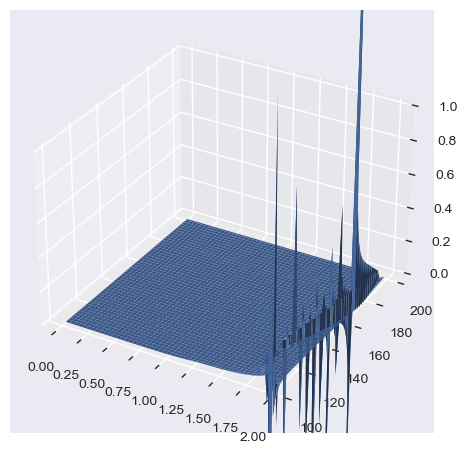

In [265]:
def Local_Volatility_Surface(Implied_Vololatility, S0, K_min, K_max, t_min, t_max, r, N=10000):
    
    def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type="call", model="BS"):
        omega = np.where(option_type == 'call', 1, -1)
        d1 = (np.log(S0/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = (np.log(S0/K)+(r-sigma**2/2)*T) / (sigma*np.sqrt(T))
        return S0*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)
    BlackScholes_ConditionalExpectation = np.vectorize(BlackScholes_ConditionalExpectation)
    K_list = np.linspace(K_min, K_max, N)
    t_list = np.linspace(t_min, t_max, N)
    dK = (K_max - K_min)/N
    dT = (t_max - t_min)/N
    C_matrix = np.zeros((N, N))
    C_dK = np.zeros((N-2, N-2))
    C_dT = np.zeros((N-2, N-2))
    C_dKK = np.zeros((N-2, N-2))
    Local_Volatility = np.zeros((N-2, N-2))
    for i in range(N):
        X_pred = np.array([[x, y] for x, y in zip([t_list[i]]*N, K_list)])
        ImpliedVol_list = Implied_Vololatility.predict(X_pred)              
        C_matrix[i, :]=BlackScholes_ConditionalExpectation(S0=S0, K=K_list, T=t_list[i], sigma=ImpliedVol_list, r=r)
    print(C_matrix)
    for i in range(1, N-1):
        for j in range(1, N-1):
            C_dK[i-1, j-1] = -(C_matrix[i, j-1] - C_matrix[i, j+1]) / (2*dK)
            C_dKK[i-1, j-1] = -(C_matrix[i, j+1] + C_matrix[i, j+1] - 2*C_matrix[i, j]) / (dK**2)
            C_dT[i-1, j-1] = (C_matrix[i+1, j] - C_matrix[i-1, j]) / (2*dT)
            numerator = C_dT[i-1, j-1] - r*C_matrix[i, j] + r*(K_min+j*dK) * C_dK[i-1, j-1]
            denominator = 0.5 * (C_dKK[i-1, j-1]*(K_min+j*dK)**2) 
            Local_Volatility[i-1, j-1] = numerator / denominator
    
    X = t_list[1: -1]
    Y = K_list[1: -1]
    X, Y = np.meshgrid(X, Y)
    print(Local_Volatility)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Local_Volatility)
    ax.set_zlim(0,1)
    return
                           
Local_Volatility_Surface(Implied_Vololatility=model, S0=163, K_min=100, K_max=200, t_min=0.001, t_max=2, r=0.0469, N=100)
                           
                           

In [254]:
model.predict([[0.4, 100]])

array([0.52296948])

In [247]:
b = [4]*5
a = [1,1,1,1,1]
model.predict(np.array([[x,y] for x, y in zip(a,b)]))

array([0.19932399, 0.19932399, 0.19932399, 0.19932399, 0.19932399])

Dynamic of Heston Model:

$$ dS_t = rS_td_t+\sqrt{v_t}S_tdW_{1,t}  $$
$$ dv_t = \kappa(\theta-v_t)d_t+\sigma\sqrt{v_t}dW_{2,t} $$
$$ dW_{1,t}dW_{2,t} = \rho d_t  $$

Feller condiation: $ 2\kappa \theta > \sigma^2 $

##  Heston Model Close Form Solution

Here we assume that we already know these parameters: $\kappa, \theta,\sigma, v_{t}, \rho $

$$ C(t,S_t) = D(t,T)E(h(S_T)) $$  

$$ = D(t,T)\int^{\infty}_{K}(S_T-K)f(S_T)dS_T $$  

$$ = D(t,T)\int^{\infty}_{log(K)}(e^X-K)f(X)dX $$

Based on the Gil-Pelaez theorem:

$$ F(x) = \frac{1}{2} - \frac{1}{\pi}\int^{\infty}_{0}Re(\frac{e^{-iwx}\varphi_X(w)}{iw})dw $$

here we have:

$$ C_t = S_t\Pi_1 - D(t,T)K\Pi_2 $$
$$ P_t = -S_t(1- \Pi_1) + D(t,T)K(1-\Pi_2) $$

$$ \Pi_1 = \frac{1}{2} - \frac{1}{\pi}\int^{\infty}_{0}Re(\frac{e^{-iwln(K)}\varphi^{Heston}_{lnS}(w-i)}{iw\varphi^{Heston}_{lnS}(-i)})dw $$

$$ \Pi_2 = \frac{1}{2} - \frac{1}{\pi}\int^{\infty}_{0}Re(\frac{e^{-iwln(K)}\varphi^{Heston}_{lnS}(w)}{iw})dw $$

While the caracteristic function for Heston model will change.

$$  \varphi_{lnS}^{Heston}(w) = exp(C(T,\omega) \bar{V}+D(T, \omega)V_t+i\omega ln(S_te^{r(T-t)}) $$
$$ C(T,\omega) = \kappa [r_{-}t-\frac{2}{\sigma^2}ln(\frac{1-ge^{-h(T-t)}}{1-g})]$$
$$ D(T,\omega) = r_{-}\frac{1-e^{-h(T-t)}}{1-ge^{-h(T-t)}}$$
$$ r_{\pm}=\frac{\beta \pm h}{\sigma^2}; h=\sqrt{\beta^2-4\alpha \gamma}$$
$$ g = \frac{r_{-}}{r_{+}}$$
$$ \alpha = -\frac{\omega ^2}{2}- \frac{i\omega}{2}; \beta=\alpha-\rho\sigma i\omega ; \gamma=\frac{\sigma^2}{2}$$


In [209]:
len(yf.Ticker('AAPL').options)

21

In [ ]:
def Heston_CharacteristicFunction(S0:float, K:float, T:float, r:float, params:list[float]=(1, 0.04, 0.2, -0.7, 0.04), 
                                  option_type:str="call", model:str='Heston') -> float:
    
    #Params: kappa=1, theta=0.04, sigma=0.2, rho=-0.7, v0=0.04
    
    if option_type in ("call", "put"):
        omega = {"call": 1, "put": -1}.get(option_type)
    else:
        ValueError("Invalid input for 'option_type'")
        
    i = complex(0, 1)
    
    def heston_characteristic_function(u, S, T, r, params):
        kappa, theta, sigma, rho, v0 = params

        alpha = -u**2 / 2 - i * u / 2
        beta = kappa - rho * sigma * i * u
        gamma = sigma**2 / 2

        h = np.sqrt(beta**2 - 4 * alpha * gamma)
        rplus = (beta + h) / (2 * gamma)
        rminus = (beta - h) / (2 * gamma)

        g = rminus / rplus

        C = kappa * (rminus * T - 2 * np.log((1 - g * np.exp(-h * T)) / (1 - g)) / sigma**2)
        D = rminus * (1 - np.exp(-h * T)) / (1 - g * np.exp(-h * T))

        return np.exp(C * theta + D * v0 + i * u * np.log(S*np.exp(r*T)))

    def integrand_1(u, S, K, T, r, params):
        cf = heston_characteristic_function
        numerator = np.exp(-i*u*np.log(K))*cf(u-i,S, T, r, params)
        denominator = i*u*cf(-i, S, T, r, params)
        return np.real(numerator/denominator)

    def integrand_2(u, S, K, T, r, params):
        cf = heston_characteristic_function
        numerator = np.exp(-i*u*np.log(K))*cf(u, S, T, r, params)
        denominator = i*u
        return np.real(numerator/denominator)
    
    Pi_1 = 0.5 + quad(integrand_1, 0, np.inf, args=(S0, K, T, r, params))[0]/np.pi
    Pi_2 = 0.5 + quad(integrand_2, 0, np.inf, args=(S0, K, T, r, params))[0]/np.pi
    
    
    payoff = lambda x: x*Pi_1-np.exp(-r*T)*K*Pi_2 if omega==1 else np.exp(-r*T)*K*(1-Pi_2)-x*(1-Pi_1)

    return payoff(S0)


kappa = 1
theta = 0.04
sigma = 0.2
rho = -0.7
v0 = 0.04
params = (kappa, theta, sigma, rho, v0)
S0 = 100
T = 1
K=100
r=0.1

Heston_CharacteristicFunction(S0=100, K=100, T=1, r=0.1, params=(kappa, theta, sigma, rho, v0), option_type="call")



In [ ]:
call = Heston_CharacteristicFunction(S0, K, t, r, params, "call")
put = Heston_CharacteristicFunction(S0, K, t, r, params, "put")
print(call + K*np.exp(-r*t))
print(put + S)

# Heston model also meets the put-call parity.

## Finite Difference Method for Pricing Heston Model

### Explicit Euler Scheme

$$ \frac{u_{i,j}^{n+1}-u_{i,j}^n}{\Delta t} = [(s_i)^2v_j\frac{u_{i+1,j}-2u_{i-1,j}+u_{i,j}}{2(\Delta s)^2} + \rho\sigma s_iv_i\frac{u_{i+1,j+1}+u_{i-1,j-1}-u_{i-1,j+1}-u_{i+1,j-1}}{4\Delta s\Delta v}+\sigma^2v_j\frac{u_{i,j+1}-u_{i,j}+u_{i,j-1}}{2(\Delta v)^2}+rs_i\frac{u_{i+1,j}-2u_{i,j}+u_{i,j-1}}{2\Delta s}+\kappa (\theta - v_j)\frac{u_{i,j+1}-u_{i,j-1}}{2\Delta v}-ru_{i,j}]     $$

After:

$$  u_{i,j}^{n+1}=A_{i,j}^nu_{i,j}^n + C_{i,j}^nu_{i-1,j}^n + D_{i,j}^nu_{i+1,j}^n + E_{i,j}^nu_{i,j-1}^n+F_{i,j}^nu_{i,j+1}^n+B_{i,j}^n(u_{i-1,j-1}^n-u_{i-1,j+1}^n-u_{i+1,j-1}^n +u_{i+1,j+1}^n) $$

$$  A_{i,j}^n=-i^2v_j\Delta t - \frac{\sigma^2j\Delta t}{\Delta v} + 1 -r\Delta t  $$
$$  C_{i,j}^n=(\frac{i^2v_j}{2} - \frac{ri}{2})\Delta t  $$
$$  D_{i,j}^n = (\frac{i^2v_j}{2} + \frac{ri}{2})\Delta t  $$
$$  E_{i,j}^n=(\frac{\sigma^2j}{2\Delta v}-\frac{\kappa (\theta-v_j)}{2\Delta v})\Delta t  $$
$$  F_{i,j}^n=(\frac{\sigma ^2j}{2\Delta v}+\frac{\kappa(\theta-v_j)}{2\Delta v})\Delta t  $$
$$  B_{i,j}^n = \frac{\rho \sigma ij}{4}\Delta t   $$

In [ ]:
def Heston_ExplicitEuler(S0:float, K:float, r:float, T:float, N:int=5, params:list[float]=(1, 0.04, 0.2, -0.7, 0.04)) -> float:
    
    #params: kappa, theta, sigma, rho, v0
    kappa, theta, sigma, rho, v0 = params
    M = np.zeros(((N**2)+1, N+1, N+1)) # Price, time, volatility
    S_max = 4 * K
    dS = S_max / N
    dt = T / (N**2)
    dv = 8.0 / N   # Here we assume the maximum of volatity is 5.
    
    # Boundary conditions
    M[:, 0, :] = 0
    for i in range((N**2)+1):
        for j in range(N+1):
            M[i, j, 0] = np.maximum(j*dS - K*np.exp(-r*(N-i)*dt), 0)
    for i in range((N**2)+1):
        M[i, N, :] = S_max - K * np.exp(-r*(N-i)*dt)
    for i in range(N+1):
        M[:, i, N] = np.maximum(i * dS - K, 0.0)
        M[N**2, i, :] = np.maximum(i*dS - K, 0.0)

    for k in range(M.shape[1]-2, -1, -1):

        for j in range(M.shape[2]-2, 0, -1):
            i = M.shape[1]-1
            A = -(i**2)*j*dv*dt - sigma**2*j*dt/dv + 1 - r*dt
            B = rho*sigma*i*j*dt/4
            C = ((i**2)*j*dv/2 - r*i/2)*dt
            E = ((sigma**2)*j/(2*dv) - kappa*(theta-dv*j)/(2*dv))*dt
            F = ((sigma**2)*j/(2*dv) + kappa*(theta-dv*j)/(2*dv))*dt
            M[k, i ,j] = np.maximum(A*M[k+1,i,j] + C*M[k+1,i-1,j] + E*M[k+1,i,j-1] + F*M[k+1,i,j+1]+ B*(M[k+1,i-1,j-1] - M[k+1,i-1,j+1]), 0)

        for i in range(M.shape[1]-2, 0, -1):
            for j in range(M.shape[2]-2, 0, -1):
                A = -(i**2)*j*dv*dt - sigma**2*j*dt/dv + 1 - r*dt
                B = rho*sigma*i*j*dt/4
                C = ((i**2)*j*dv/2 - r*i/2)*dt
                D = ((i**2)*j*dv/2 + r*i/2)*dt
                E = ((sigma**2)*j/(2*dv) - kappa*(theta-dv*j)/(2*dv))*dt
                F = ((sigma**2)*j/(2*dv) + kappa*(theta-dv*j)/(2*dv))*dt
                M[k, i ,j] = np.maximum(A*M[k+1,i,j] + C*M[k+1,i-1,j] + D*M[k+1,i+1,j] + E*M[k+1,i,j-1] + F*M[k+1,i,j+1] \
                + B*(M[k+1,i-1,j-1] - M[k+1,i-1,j+1] - M[k+1,i+1,j-1] + M[k+1,i+1,j+1]), 0)
    print("The option price is: ", M[0, N//4,0])
    
    #return pd.DataFrame(M[0][::-1])
    return M[-5:]

### Implicit Euler Scheme (ADI)

## Monte-Carlo Simulation for Heston

### Euler-Maruyama Scheme for Heston Model

The dynamic of Heston model:
$$ dS_t = rS_tdt + \sqrt{v_t}S_tdW_{1,t} $$ 
$$ dv_t = \kappa (\theta - v_t)dt + \sigma \sqrt{v_t}dW_{2,t} $$ 

Feller Condition: $$ 2\kappa \theta - \sigma^2 > 0 $$

Generate 2 random number, $Z_v$, $ Z_s$ with correlation $\rho $:
$$ v_{t+dt} = v_t + \kappa (\theta -v_t)dt+\sigma\sqrt{v_td_t}Z_{v,t} $$
$$ S_{t+dt} = S_t + rS_tdt+\sqrt{v_tdt}S_tZ_{s,t} $$

In [ ]:
import inspect

def Heston_Analyser(func):
    def wrapper(*args, **kwargs):
        # params: S0=100, K=100, T=1, sigma=0.2, r=0.1, option_type='call', model='BS', N=1000000, steps = 1000
        #        seed=42, cores = 8
        def payoff(S_T, K, option_type):
            if option_type == 'call':
                res = np.maximum(S_T - K, 0)
            elif option_type == 'put':
                res = np.maximum(K - S_T, 0)
            return res
        payoff = np.vectorize(payoff)
        
        def confidence_interval(data, confidence=0.95):
            mean = np.mean(data)
            standard_error = stats.sem(data)
            degrees_of_freedom = len(data) - 1
            interval = stats.t.interval(confidence, degrees_of_freedom, mean, standard_error)
            return interval
        
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        
        S0 = bound_arguments.arguments.get('S0')
        K = bound_arguments.arguments.get('K')
        T = bound_arguments.arguments.get('T')
        r = bound_arguments.arguments.get('r')
        option_type = bound_arguments.arguments.get('option_type')
        model = bound_arguments.arguments.get('model')
        N = bound_arguments.arguments.get('N')
        seed = bound_arguments.arguments.get('seed')
        cores = bound_arguments.arguments.get('cores')
        
        if model=='BS':
            sigma = bound_arguments.arguments.get('sigma')
        if model=='Heston':
            params = bound_arguments.arguments.get('params')
            
        step = N // 100   
        option_map = {'call':0, 'put':1}

        output = np.array(Parallel(n_jobs=cores)(delayed(func)(S0=S0, K=K, T=T, r=r,
            N=int(0.1*N/cores), seed=i*100) for i in range(cores*10)))
        output = output.flatten()
        
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(8, 6))
        res = 0
        
        for opt in ('call', 'put'):
            means = []
            variances = []
            confidence = []
            
            if model == "BS":
                true_value = BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, sigma=sigma, r=r, option_type=opt)
            elif model == "Heston":
                true_value = Heston_CharacteristicFunction(S0=S0, K=K, T=T, r=r, params=params, 
                                                           option_type=opt, model='Heston')
            for i in range(step, N+1, step):
                data = np.exp(-r*T) * payoff(output[:i], K, opt)
                means.append(np.mean(data))
                variances.append(np.var(data, ddof=1))
                confidence.append(confidence_interval(data))
            err = round((np.abs(means[-1] - true_value) / true_value)*100, 2)
            x = np.arange(step, N+1, step)
            lower_bound = [interval[0] for interval in confidence]
            upper_bound = [interval[1] for interval in confidence]

            axs[option_map[opt]].plot(x, means, label='Mean')
            axs[option_map[opt]].fill_between(x, lower_bound, upper_bound, color='red', alpha=0.3, label='5% Confidence Interval')
            axs[option_map[opt]].set_xlabel('Iteration')
            axs[option_map[opt]].set_ylabel('Value')
            axs[option_map[opt]].set_title('Monte Carlo Simulation with 5% Confidence Interval for {} option'.format(opt))
            axs[option_map[opt]].axhline(y=true_value, color='g', linestyle='--', label='real value')
            axs[option_map[opt]].legend(loc = 'best')
        
            print(" the {} option price is: {}\n".format(opt, means[-1]),"the true value is: {}\n".format(true_value), \
                 "the {} option error is: {}% \n".format(opt, err))
            
            if option_type == opt:
                res = means[-1]

        plt.tight_layout()
        plt.show()
            
        return res
    return wrapper

In [ ]:
N = 50000
steps=1000
T = 1
S0=100
K=100
T=1
r=0.1
params=(2, 0.04, 0.3, -0.7, 0.04)
s = 0.2
kappa, theta, sigma, rho, v0 = params

z1 = np.random.normal(size=(N, steps))
z2 = np.random.normal(size=(N, steps))
rvs_s = np.random.normal(size=(N, steps))
rvs_v = np.random.normal(size=(N, steps))   
dt = T/steps
for i in range(N):
    rvs_s[i, :] = z1[i, :]
    rvs_v[i, :] = rho*z1[i, :]+np.sqrt(1-rho**2)*z2[i, :]

S_matrix = np.zeros((N, steps))
s2 = np.zeros((N, steps))
v_matrix = np.zeros((N, steps))
S_matrix[:, 0] = S0
v_matrix[:, 0] = v0
s2[:, 0] = S0

for i in range(1, steps):
    v_matrix[:, i] = np.maximum(v_matrix[:, i-1] + kappa*(theta-v_matrix[:, i-1])*dt + sigma*np.sqrt(v_matrix[:, i-1]*dt)*rvs_v[:, i-1], 0.0001)
    S_matrix[:, i] = S_matrix[:, i-1] + r*S_matrix[:, i-1]*dt + S_matrix[:, i-1]*np.sqrt(v_matrix[:, i-1]*dt)*rvs_s[:, i-1]
    s2[:, i] = s2[:, i-1] + r*s2[:, i-1]*dt + s2[:, i-1]*s*np.sqrt(dt)*rvs_s[:, i-1]
plt.hist(S_matrix[:, -1], bins=50, color='red', alpha=0.5, label='Heston')
plt.hist(s2[:, -1], bins=50, color='b', alpha=0.5, label='BS')
plt.legend()
plt.show()


In [ ]:
@Heston_Analyser
def Heston_MonteCarlo_Euler(S0:float, K:float, T:float, r:float, params:list[float]=(2, 0.04, 0.3, -0.7, 0.04), 
                            N:int=10000, steps:int=1000, model:str='Heston', option_type:str='call', seed:int=42, 
                            cores:int=8) -> float:
    kappa, theta, sigma, rho, v0 = params
    np.random.seed(seed)
    z1 = np.random.normal(size=(N, steps))
    z2 = np.random.normal(size=(N, steps))
    rvs_s = np.random.normal(size=(N, steps))
    rvs_v = np.random.normal(size=(N, steps))   
    dt = T/steps
    for i in range(N):
        rvs_s[i, :] = z1[i, :]
        rvs_v[i, :] = rho*z1[i, :]+np.sqrt(1-rho**2)*z2[i, :]
    
    
    S_matrix = np.zeros((N, steps))
    v_matrix = np.zeros((N, steps))
    S_matrix[:, 0] = S0
    v_matrix[:, 0] = v0
    
    for i in range(1, steps):
        v_matrix[:, i] = np.maximum(v_matrix[:, i-1] + kappa*(theta-v_matrix[:, i-1])*dt + sigma*np.sqrt(v_matrix[:, i-1]*dt)*rvs_v[:, i-1], 0)
        S_matrix[:, i] = S_matrix[:, i-1] + r*S_matrix[:, i-1]*dt + S_matrix[:, i-1]*np.sqrt(v_matrix[:, i-1]*dt)*rvs_s[:, i-1]

    return S_matrix[:, -1]

res = Heston_MonteCarlo_Euler(S0=100, K=100, T=1, r=0.1, params=(1, 0.04, 0.2, -0.7, 0.04),
                              N=100000, steps=1000)


In [ ]:
@Heston_Analyser
def Heston_MonteCarlo_Euler_logS(S0=100, K=100, T=1, r=0.1, params=(2, 0.04, 0.3, -0.7, 0.04), 
                            N=10000, steps=1000, model='Heston', option_type='call', seed=42, cores=8):
    kappa, theta, sigma, rho, v0 = params
    np.random.seed(seed)
    z1 = np.random.normal(size=(N, steps))
    z2 = np.random.normal(size=(N, steps))
    rvs_s = np.random.normal(size=(N, steps))
    rvs_v = np.random.normal(size=(N, steps))   
    dt = T/steps
    for i in range(N):
        rvs_s[i, :] = z1[i, :]
        rvs_v[i, :] = rho*z1[i, :]+np.sqrt(1-rho**2)*z2[i, :]
    
    
    S_matrix = np.zeros((N, steps))
    v_matrix = np.zeros((N, steps))
    S_matrix[:, 0] = S0
    v_matrix[:, 0] = v0
    
    for i in range(1, steps):
        v_matrix[:, i] = np.maximum(v_matrix[:, i-1] + kappa*(theta-v_matrix[:, i-1])*dt + 
                                    sigma*np.sqrt(v_matrix[:, i-1]*dt)*rvs_v[:, i-1], 0)
        S_matrix[:, i] = S_matrix[:, i-1]*np.exp((r-0.5*v_matrix[:, i-1])*dt + 
                                    np.sqrt(v_matrix[:, i-1]*dt)*rvs_s[:, i-1])

    return S_matrix[:, -1]

res = Heston_MonteCarlo_Euler_logS(S0=100, K=100, T=1, r=0.1, params=(2, 0.04, 0.2, -0.7, 0.04),
                              N=100000, steps=1000, cores=8)

### Milstein scheme for Heston model

Restate the dynamic of Heston model:

$$ dS_t = rS_tdt + \sqrt{v_t}S_tdW_{1,t} $$ 
$$ dv_t = k(\theta - v_t)dt + \sigma \sqrt{v_t}dW_{2,t} $$

Restate the result of Milstein scheme in Black Scholes Model:

$$ S_{t+dt}=S_t + \mu(S_t)dt+\sigma(S_t)\sqrt{dt}Z+\frac{1}{2}\sigma(S_t)'\sigma(S_t)dt(Z^2-1) $$

discritization of the brownian motion:
$$ v_{t+dt}=v_t+k(\theta-v_t)dt+\sigma\sqrt{v_tdt}Z_v+\frac{1}{4}\sigma^2dt(Z_v^2-1) $$
$$ S_{t+dt}=S_t+rS_tdt+\sqrt{v_tdt}S_tZ_s+\frac{1}{2}v_tS_tdt(Z_s^2-1) $$

For log-heston case, the Miltein is equal to Euler-Maruyama. ($\sigma'(S_t)=0$ and $\mu'(S_t)=0$) 

For heston case, generate 2 random number $Z_v$ and $Z_s$ with correlation $\rho$

In [ ]:
@Heston_Analyser
def Heston_MonteCarlo_Milstein(S0:float, K:float, T:float, r:float, params:list[float]=(2, 0.04, 0.3, -0.7, 0.04), 
                            N:int=10000, steps:int=1000, model:str='Heston', option_type:str='call', 
                            seed:int=42, cores:int=8) -> float:
    kappa, theta, sigma, rho, v0 = params
    np.random.seed(seed)
    z1 = np.random.normal(size=(N, steps))
    z2 = np.random.normal(size=(N, steps))
    rvs_s = np.random.normal(size=(N, steps))
    rvs_v = np.random.normal(size=(N, steps))   
    dt = T/steps
    for i in range(N):
        rvs_s[i, :] = z1[i, :]
        rvs_v[i, :] = rho*z1[i, :]+np.sqrt(1-rho**2)*z2[i, :]
    
    
    S_matrix = np.zeros((N, steps))
    v_matrix = np.zeros((N, steps))
    S_matrix[:, 0] = S0
    v_matrix[:, 0] = v0
    
    for i in range(1, steps):
        v_matrix[:, i] = np.maximum(v_matrix[:, i-1] + kappa*(theta-v_matrix[:, i-1])*dt +
                                    sigma*np.sqrt(v_matrix[:, i-1]*dt)*rvs_v[:, i-1]+
                                    0.25*(sigma**2)*dt*((rvs_v[:, i-1]**2)-1), 0)
        S_matrix[:, i] = (S_matrix[:, i-1] + r*S_matrix[:, i-1]*dt + 
                            S_matrix[:, i-1]*np.sqrt(v_matrix[:, i-1]*dt)*rvs_s[:, i-1] +
                            0.5*v_matrix[:, i-1]*S_matrix[:, i-1]*dt*((rvs_s[:, i-1]**2)-1))

    return S_matrix[:, -1]

res = Heston_MonteCarlo_Milstein(S0=100, K=100, T=1, r=0.1, params=(2, 0.04, 0.2, -0.7, 0.04),
                              N=100000, steps=1000)

## Calibration of the Parameters

Minimize the objective function that calculates the mean squared error (MSE) between the market option prices and the Heston model option prices.

The objective function should take the Heston model parameters as input and output the MSE value.

$$ minS(\Omega)=min \sum^N_{i=1}\omega_i[C_i^\Omega(K_i,T_i)-C_i^M(K_i,T_i)]$$

In [ ]:
# Define the mean squared error function
def Heston_Calibrate(ticker, opt_method):
    def mean_squared_error(params, *args):
        kappa, theta, sigma, rho, v0 = params
        S, K, T, r, market_prices = args
        heston_prices = [Heston_CharacteristicFunction(S=S, K=K[i], t=T[i], r=r, params=params) for i in range(len(K))]
        return np.mean((market_prices - heston_prices) ** 2)

    stock = yf.Ticker(ticker)
    option_chain = stock.option_chain(aapl.options[0])
    calls = option_chain.calls
    S = stock.info['regularMarketPrice']
    r = 0.01  # Assume a risk-free interest rate of 1%
    
    market_prices = calls['lastPrice'].values
    K = calls['strike'].values
    expiration_date = datetime.datetime.strptime(aapl.options[0], "%Y-%m-%d").date()
    current_date = datetime.datetime.today().date()
    time_to_expiration = (expiration_date - current_date).days / 365.0
    T = np.full(len(K), time_to_expiration)

    bounds = [
        (0.1, 5.0),  # kappa
        (0.01, 0.99),  # theta
        (0.01, 5.0),  # sigma
        (-0.99, 0.99),  # rho
        (0.01, 5.0),  # v0
    ]

    init_params = [1.0, 0.06, 0.3, -0.1, 0.04]

    res = minimize(mean_squared_error, init_params, bounds=bounds, args=(S, K, T, r, market_prices), method=opt_method)

    print("Optimal Heston model parameters:")
    print("Kappa: ", res.x[0])
    print("Theta: ", res.x[1])
    print("Sigma: ", res.x[2])
    print("Rho:   ", res.x[3])
    print("V0:    ", res.x[4])
    return res


In [ ]:
parameters = Heston_Calibrate(ticker='AAPL', opt_method="SLSQP")
print(parameters)

## Implied Volatility

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 生成三维数据
def generate_3d_data(num_samples):
    np.random.seed(42)
    x = np.random.rand(num_samples, 1)
    y = np.random.rand(num_samples, 1)
    z = 2 * x * y + 8*((x-0.5)**2)*y + 0.3 * np.random.randn(num_samples, 1)
    return np.hstack([x, y]), z

# 训练和预测
def train_and_predict_ridge_regression(X, y, degree=3, alpha=1.0):
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
    model.fit(X, y)
    return model, model.predict(X)

# 绘制散点图和拟合的平面
def plot_3d_scatter_and_fitted_plane(X, y, y_pred):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 绘制散点图
    ax.scatter(X[:, 0], X[:, 1], y, c='b', marker='o', label='Original data')

    # 绘制拟合平面
    x0_range = np.linspace(X[:, 0].min(), X[:, 0].max(), num=30)
    x1_range = np.linspace(X[:, 1].min(), X[:, 1].max(), num=30)
    x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
    X_grid = np.hstack([x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)])
    y_grid_pred = model.predict(X_grid).reshape(x0_grid.shape)
    ax.plot_surface(x0_grid, x1_grid, y_grid_pred, color='r', alpha=0.5, label='Fitted plane')

    # 设置图例和坐标轴标签
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    plt.show()

# 主程序
if __name__ == "__main__":
    X, y = generate_3d_data(200)
    model, y_pred = train_and_predict_ridge_regression(X, y, degree=3, alpha=1.0)
    plot_3d_scatter_and_fitted_plane(X, y, y_pred)


## Mark


In [47]:
from scipy.stats import norm

# Initial one
def ImpliedVolatilitySurface(date_list, options_data, ticker='AAPL', cores=8, poly=4, panalty=0.3, current_price=100, 
                             lr=1, sigma_init=3, tol=0.0001):
    def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, q=0.1, option_type="call", model="BS"):
        Indicator = lambda x: 1 if x=='call' else -1
        omega = Indicator(option_type)
        d1 = (np.log(S0/K)+(r-q+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = (np.log(S0/K)+(r-q-sigma**2/2)*T) / (sigma*np.sqrt(T))
        return S0*np.exp(-q*T)*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

    def get_risk_free_rate():
        fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
        fred = Fred(api_key=fred_api_key)
        return fred.get_series('TB3MS')[-1] / 100

    def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr_init=1, sigma_init=1, tol=tol):
            
        def error_function(sigma):
            return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, option_type=option_type) - market_price
        
        def vega(sigma):
            d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)

        def adjust_sigma(sigma, loss):
            Indicator = lambda x: 0.8 if x > 0 else 1.25
            indicator = Indicator(loss)
            return sigma * indicator
        
        sigma1 = sigma2 = sigma_init
        loss1 = loss2 = error_function(sigma1)
        lr = lr_init
        while np.abs(loss2) >= tol:
            if sigma1 <= 0:
                sigma1 = 0.5
                #print('sigma cannot be negative, readjust to 0.5')
            loss1 = error_function(sigma1)
            #print(sigma1)
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("error", category=RuntimeWarning)
                    adjusted_value = lr * error_function(sigma1) / vega(sigma1)
                    sigma2 = sigma1 - adjusted_value
                    loss2 = error_function(sigma2)
                    if loss1*loss2 > 0:
                        sigma1 = sigma2
                        loss1=loss2
                    else:
                        if lr > 0.1:
                            lr = lr / 3
                        else:
                            #print('error function is {} '.format(loss1))
                            #print('S0={}, K={}, T={}, P={}'.format(S0, K, T, market_price))
                            sigma1 = adjust_sigma(sigma1, loss1)
                            #print('change sigma to{}'.format(sigma1))
            except ZeroDivisionError:
                sigma1 = adjust_sigma(sigma1, loss1)
                #print('ZeroDivisionError, error function is {}, readjust sigma {} '.format(loss1, sigma1))
                #print('S0={}, K={}, T={}, market_price={}'.format(S0,K,T,market_price))
                loss2 = error_function(sigma1)
                lr=lr_init
            except FloatingPointError:
                sigma1 = adjust_sigma(sigma1, loss1)
                #print('FloatingPointError, error function is {}, readjust sigma {} '.format(loss1, sigma1))
                #print('S0={}, K={}, T={}, market_price={}'.format(S0,K,T,market_price))
                loss2 = error_function(sigma1)
                lr=lr_init
            except RuntimeWarning:
                sigma1 = adjust_sigma(sigma1, loss1)
                #print('RuntimeWarning, error function is {}, readjust sigma {} '.format(loss1, sigma1))
                #print('S0={}, K={}, T={}, market_price={}'.format(S0,K,T,market_price))
                loss2 = error_function(sigma1)
                lr=lr_init
        return sigma1

    BlackScholes_Implied_Vol = np.vectorize(BlackScholes_Implied_Vol)

    current_stock_price = current_price
    today = datetime.date.today()
    risk_free_rate = get_risk_free_rate()

    options = []
    for i in range(len(date_list)):
        options_data[i]['Maturity'] = (datetime.datetime.strptime(date_list[i],"%Y-%m-%d").date() - today).days/365
        options_data[i]['option_type'] = options_data[i]['contractSymbol'].apply(lambda x:'call' if x[-9]=='C' else 'put')
        options_data[i]['mid'] = (options_data[i]['bid']+options_data[i]['ask'])/2
        options_data[i]['minimum'] = np.where(options_data[i]['option_type']=='call', current_stock_price-options_data[i]['strike']*
                                              np.exp(-risk_free_rate*options_data[i]['Maturity']), options_data[i]['strike']*
                                              np.exp(-risk_free_rate*options_data[i]['Maturity']) - current_stock_price)
        options_data[i] = options_data[i][options_data[i]['minimum'] < options_data[i]['mid']]
        options_data[i]['Implied_Vol'] = BlackScholes_Implied_Vol(S0 = current_stock_price, K = options_data[i]['strike'],
                                                            T = options_data[i]['Maturity'], r = risk_free_rate, q=0, 
                                                            market_price = options_data[i]['mid'], 
                                                            option_type = options_data[i]['option_type'], tol = tol)
        options_data[i].loc[(options_data[i]['Implied_Vol'] > 5) | (options_data[i]['Implied_Vol'] < -5), 'Implied_Vol'] = 0
        options.append(options_data[i])

    return options

In [ ]:
#Vectorize version 1
def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr_init, sigma_init, tol=0.00001):
        minimum_value = np.where(option_type=='call', S0-K*np.exp(-r*T), K*np.exp(-r*T)-S0)
        sigma1 = sigma2 = np.where(minimum_value > market_price, 0, sigma_init)
        loss1 = loss2 = error_function(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price)
        lr = lr_init

        error_function_vectorized = np.vectorize(error_function)
        adjust_sigma_vectorized = np.vectorize(adjust_sigma)

        while np.any(np.abs(loss2) >= tol):
            sigma1 = np.where(sigma1 < 0, 0.5, sigma1)

            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("error", category=RuntimeWarning)

                    loss1 = np.where(sigma1 != 0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price), 0)
                    vega1 = np.where(sigma1 != 0, vega(S0=S0, K=K, T=T, r=r, sigma=sigma1, q=0), 100)
                    lr = np.where(np.abs(loss1)<= tol, 0, lr)
                    
                    sigma2 = sigma1 - lr * loss1 / vega1
                    loss2 = np.where(sigma1 != 0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma2, option_type=option_type, market_price=market_price), 0)

                    update_condition = loss1 * loss2 > 0
                    sigma1 = np.where(update_condition, sigma2, sigma1)
                    loss1 = np.where(update_condition, loss2, loss1)

                    lr = np.where(loss1 * loss2 < 0, np.where(lr > 0.1, lr / 3, lr), lr)

                    adjust_condition = (loss1 * loss2 < 0) & (lr <= 0.1)
                    sigma1 = np.where(adjust_condition, adjust_sigma_vectorized(sigma1, loss1), sigma1)

            except (ZeroDivisionError, FloatingPointError, RuntimeWarning):
                vega_zero_index = np.where(vega1==0)
                loss_inf_index = np.where(np.isinf)
                if isinstance(e, RuntimeWarning):
                    error_indices - np.where()
                sigma1 = adjust_sigma_vectorized(sigma1, loss1)
                loss2 = error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price)
                lr = lr_init
            

        return sigma1


In [163]:
a = pd.Series([1,2])
b = pd.Series([1,0])
a/b

0   1.00
1    inf
dtype: float64

In [166]:
a = np.array([1,1,1,1])
b = np.array([1, 3, 5 ,0])
c = a / b
c[np.where(np.isinf(c))] = 2
c
    


        

array([1.        , 0.33333333, 0.2       , 2.        ])

In [140]:
np.isinf(-np.inf)

True

In [170]:
from scipy.stats import norm

# Vectorized method
def ImpliedVolatilitySurface(date_list, options_data, ticker='AAPL', cores=8, poly=4, panalty=0.3, current_price=100, 
                             lr=1, sigma_init=3, tol=0.0001):
    def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, q=0.1, option_type="call", model="BS"):
        omega = np.where(option_type == 'call', 1, -1)
        d1 = (np.log(S0/K)+(r-q+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = (np.log(S0/K)+(r-q-sigma**2/2)*T) / (sigma*np.sqrt(T))
        return S0*np.exp(-q*T)*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

    def get_risk_free_rate():
        fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
        fred = Fred(api_key=fred_api_key)
        return fred.get_series('TB3MS')[-1] / 100
    
    def error_function(S0, K, T, r, sigma, market_price, option_type, q=0):
        return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, option_type=option_type) - market_price

    def vega(S0, K, T, r, sigma, q=0):
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)
    
    def adjust_sigma(sigma, loss):
        return np.where(loss>0, sigma*0.5, sigma*2)
    
    def minimum_payoff(S0, K, T, r, option_type):
        return np.where(option_type == 'call', S0 - K * np.exp(-T * r), K * np.exp(-T * r) - S0)

    def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr_init, sigma_init, tol=0.00001):
        #minimum_value = np.where(option_type=='call', S0-K*np.exp(-r*T), K*np.exp(-r*T)-S0)
        sigma1 = sigma2 = sigma_init
        loss1 = loss2 = error_function(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price)
        lr = lr_init

        error_function_vectorized = np.vectorize(error_function)
        adjust_sigma_vectorized = np.vectorize(adjust_sigma)

        while np.any(np.abs(loss2) >= tol):
            
            lr = np.where(np.abs(loss1)<tol, 0, lr)
            sigma1 = sigma2
            loss1 = np.where(lr!=0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma1, option_type=option_type, market_price=market_price), 0)
            vega1 = np.where(lr!=0, vega(S0=S0, K=K, T=T, r=r, sigma=sigma1, q=0), 0)
            sigma2 = np.where(lr!=0, sigma1 - lr*loss1/vega1, 0)
            loss2 = np.where(lr!=0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma2, option_type=option_type, market_price=market_price), 0)
            sigma1 = np.where(loss1*loss2>0, sigma2, sigma1)
            lr = np.where(loss1*loss2<0, np.where(lr >0.01, lr/3, lr), lr)
            sigma2 = np.where(loss1*loss2<0, np.where(lr<=0.01, adjust_sigma_vectorized(sigma1, loss1),sigma1),sigma1)                 
            loss2 = np.where(lr!=0, error_function_vectorized(S0=S0, K=K, r=r, T=T, sigma=sigma2, option_type=option_type, market_price=market_price), 0)

        return sigma2

    BlackScholes_Implied_Vol = np.vectorize(BlackScholes_Implied_Vol)

    current_stock_price = current_price
    today = datetime.date.today()
    risk_free_rate = get_risk_free_rate()

    options = []
    for i in range(len(date_list)):
        options_data[i]['Maturity'] = (datetime.datetime.strptime(date_list[i],"%Y-%m-%d").date() - today).days/365
        options_data[i]['option_type'] = options_data[i]['contractSymbol'].apply(lambda x:'call' if x[-9]=='C' else 'put')
        options_data[i]['lr'] = 1
        options_data[i]['sigma_init'] = 3
        options_data[i]['mid'] = (options_data[i]['bid']+options_data[i]['ask'])/2
        options_data[i]['minimum'] = np.where(options_data[i]['option_type']=='call', current_stock_price-options_data[i]['strike']*
                                      np.exp(-risk_free_rate*options_data[i]['Maturity']), options_data[i]['strike']*
                                      np.exp(-risk_free_rate*options_data[i]['Maturity']) - current_stock_price)
        options_data[i] = options_data[i][options_data[i]['minimum'] < options_data[i]['mid']]
        options_data[i]['Implied_Vol'] = BlackScholes_Implied_Vol(S0 = current_stock_price, K = options_data[i]['strike'], T = options_data[i]['Maturity'], sigma_init= options_data[i]['sigma_init'],
                                                            r = risk_free_rate, q=0, market_price = options_data[i]['mid'], option_type = options_data[i]['option_type'], 
                                                            lr_init=options_data[i]['lr'], tol = tol)
        options_data[i].loc[(options_data[i]['Implied_Vol'] > 5) | (options_data[i]['Implied_Vol'] < -5), 'Implied_Vol'] = 0
        options.append(options_data[i])

    return options

In [66]:
#Oldest 
def ImpliedVolatilitySurface(date_list, options_data, ticker='AAPL', cores=8, poly=4, panalty=0.3, current_price=100, 
                             lr=1, sigma_init=3, tol=0.0001):
    def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, q=0.1, option_type="call", model="BS"):
        omega = np.where(option_type == 'call', 1, -1)
        d1 = (np.log(S0/K)+(r-q+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = (np.log(S0/K)+(r-q-sigma**2/2)*T) / (sigma*np.sqrt(T))
        return S0*np.exp(-q*T)*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

    def get_risk_free_rate():
        fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
        fred = Fred(api_key=fred_api_key)
        return fred.get_series('TB3MS')[-1] / 100
    
    def error_function(S0, K, T, r, sigma, market_price, option_type, q=0):
        return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, option_type=option_type) - market_price

    def vega(S0, K, T, r, sigma, q=0):
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)
    
    def adjust_sigma(sigma, loss):
        return np.where(loss>0, sigma*0.5, sigma*2)
    
    def minimum_payoff(S0, K, T, r, option_type):
        return np.where(option_type == 'call', S0 - K * np.exp(-T * r), K * np.exp(-T * r) - S0)

    def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr_init=1, sigma_init=1, tol=0.0001):
        def error_function(sigma):
            return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, 
                                                       option_type=option_type) - market_price
        def vega(sigma):
            d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)

        def adjust_sigma(sigma, loss):
            Indicator = lambda x: 0.5 if x > 0 else 2
            indicator = Indicator(loss)
            return sigma * indicator

        sigma1 = sigma2 = sigma_init
        loss1 = loss2 = error_function(sigma1)
        lr = lr_init
        while np.abs(loss2) >= tol:
            print(sigma1)
            try:
                with warnings.catch_warnings():
                    warnings.filterwarnings("error", category=RuntimeWarning)
                    adjusted_value = lr * error_function(sigma1) / vega(sigma1)
                    sigma2 = sigma1 - adjusted_value
                    loss2 = error_function(sigma2)
                    if loss1*loss2 > 0:
                        sigma1 = sigma2
                        loss1=loss2
                    else:
                        if lr > 0.1:
                            lr = lr / 3
                        else:
                            sigma1 = adjust_sigma(sigma1, loss1)
            except ZeroDivisionError:
                sigma1 = adjust_sigma(sigma1, loss1)
                print('ZeroDivisionError, readjust sigma ', sigma1)
                loss2 = error_function(sigma1)
                lr=lr_init
            except FloatingPointError:
                sigma1 = adjust_sigma(sigma1, loss1)
                print('FloatingPointError, readjust sigma ', sigma1)
                loss2 = error_function(sigma1)
                lr=lr_init
            except RuntimeWarning:
                sigma1 = adjust_sigma(sigma1, loss1)
                print('RuntimeWarning, readjust sigma ', sigma1)
                loss2 = error_function(sigma1)
                lr=lr_init

        return sigma1


    BlackScholes_Implied_Vol = np.vectorize(BlackScholes_Implied_Vol)

    current_stock_price = current_price
    today = datetime.date.today()
    risk_free_rate = get_risk_free_rate()

    options = []
    for i in range(len(date_list)):
        options_data[i]['Maturity'] = (datetime.datetime.strptime(date_list[i],"%Y-%m-%d").date() - today).days/365
        options_data[i]['option_type'] = options_data[i]['contractSymbol'].apply(lambda x:'call' if x[-9]=='C' else 'put')
        options_data[i]['mid'] = (options_data[i]['bid']+options_data[i]['ask'])/2
        options_data[i]['minimum'] = np.where(options_data[i]['option_type']=='call', current_stock_price-options_data[i]['strike']*
                                      np.exp(-risk_free_rate*options_data[i]['Maturity']), options_data[i]['strike']*
                                      np.exp(-risk_free_rate*options_data[i]['Maturity']) - current_stock_price)
        options_data[i] = options_data[i][options_data[i]['minimum'] < options_data[i]['mid']]
        options_data[i]['Implied_Vol'] = BlackScholes_Implied_Vol(S0 = current_stock_price, K = options_data[i]['strike'], T = options_data[i]['Maturity'], sigma_init=options_data[i]['signa']
                                                            r = risk_free_rate, q=0, market_price = options_data[i]['mid'], option_type = options_data[i]['option_type'], tol = tol)
        options_data[i].loc[(options_data[i]['Implied_Vol'] > 5) | (options_data[i]['Implied_Vol'] < -5), 'Implied_Vol'] = 0
        options.append(options_data[i])

    return options

In [178]:
def split_array(array, num_parts):
    result = []
    size_per_part = len(array) // num_parts
    remainder = len(array) % num_parts
    start = 0
    for i in range(num_parts):
        end = start + size_per_part
        if i < remainder:
            end += 1
        result.append(array[start:end])
        start = end
    return result

def split_array_df(array, num_parts):
    result = []
    size_per_part = len(array) // num_parts
    remainder = len(array) % num_parts
    start = 0
    for i in range(num_parts):
        end = start + size_per_part
        if i < remainder:
            end += 1
        result.append(array[start:end])
        start = end
    return result

ticker='AAPL'
stock = yf.Ticker('AAPL')
stock_info = stock.info
current_stock_price = stock_info['regularMarketPrice']
date_lists = stock.options

options_data = []
for date in date_lists:
    option_data = stock.option_chain(date)
    call_data = option_data.calls
    put_data = option_data.puts
    options_data.append(pd.concat([call_data, put_data]))
    
cores = 8
date_lists = split_array(array = date_lists, num_parts=cores)
option_lists = split_array_df(array = options_data, num_parts=cores)

output = np.array(Parallel(n_jobs=cores)(delayed(ImpliedVolatilitySurface)(ticker=ticker, options_data=option_lists[i],
              date_list=date_lists[i], current_price=current_stock_price,lr=1, sigma_init=2) for i in range(cores)))
#output = ImpliedVolatilitySurface(ticker=ticker, options_data=option_lists[7], date_list=date_lists[7], current_price=current_stock_price,lr=1, sigma_init=1)




In [16]:
def get_risk_free_rate():
    fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
    fred = Fred(api_key=fred_api_key)
    return fred.get_series('TB3MS')[-1] / 100
get_risk_free_rate()

0.046900000000000004

In [172]:
output[0]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,inTheMoney,contractSize,currency,Maturity,option_type,lr,sigma_init,mid,minimum,Implied_Vol
8,AAPL250620C00090000,2023-04-25 14:41:14+00:00,90.00,84.00,80.95,84.00,5.75,7.35,320.00,366,...,True,REGULAR,USD,2.16,call,1,3,82.47,82.43,0.18
9,AAPL250620C00095000,2023-04-25 14:41:13+00:00,95.00,80.15,77.05,80.15,-1.76,-2.15,1096.00,4948,...,True,REGULAR,USD,2.16,call,1,3,78.60,77.91,0.25
10,AAPL250620C00100000,2023-04-21 17:20:30+00:00,100.00,76.00,73.30,76.40,0.00,0.00,4.00,227,...,True,REGULAR,USD,2.16,call,1,3,74.85,73.39,0.27
11,AAPL250620C00105000,2023-04-21 19:46:00+00:00,105.00,72.30,69.20,71.60,0.00,0.00,1.00,149,...,True,REGULAR,USD,2.16,call,1,3,70.40,68.87,0.26
12,AAPL250620C00110000,2023-03-14 19:03:41+00:00,110.00,57.38,68.00,69.75,0.00,0.00,1.00,122,...,True,REGULAR,USD,2.16,call,1,3,68.88,64.35,0.32
13,AAPL250620C00115000,2023-04-20 17:53:39+00:00,115.00,67.40,61.55,64.40,0.00,0.00,1.00,588,...,True,REGULAR,USD,2.16,call,1,3,62.98,59.83,0.27
14,AAPL250620C00120000,2023-04-14 18:33:03+00:00,120.00,61.70,58.65,60.25,0.00,0.00,2.00,1459,...,True,REGULAR,USD,2.16,call,1,3,59.45,55.31,0.27
15,AAPL250620C00125000,2023-04-19 19:34:08+00:00,125.00,60.53,54.90,57.50,0.00,0.00,1.00,354,...,True,REGULAR,USD,2.16,call,1,3,56.20,50.79,0.28
16,AAPL250620C00130000,2023-04-20 14:11:13+00:00,130.00,56.20,52.55,53.60,0.00,0.00,5.00,985,...,True,REGULAR,USD,2.16,call,1,3,53.08,46.27,0.28
17,AAPL250620C00135000,2023-04-18 19:06:41+00:00,135.00,52.24,49.25,50.30,0.00,0.00,2.00,205,...,True,REGULAR,USD,2.16,call,1,3,49.77,41.75,0.28


In [65]:
output[0]
## Vectorize version

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Maturity,option_type,mid,minimum,Implied_Vol
7,AAPL250620C00085000,2023-03-21 13:48:45+00:00,85.00,81.50,88.80,91.20,0.00,0.00,3.00,157,0.53,True,REGULAR,USD,2.16,call,90.00,88.51,0.34
8,AAPL250620C00090000,2023-03-24 15:17:38+00:00,90.00,78.25,82.80,85.30,0.00,0.00,4.00,366,0.50,True,REGULAR,USD,2.16,call,84.05,83.99,0.19
9,AAPL250620C00095000,2023-04-19 15:26:57+00:00,95.00,81.91,79.65,81.15,0.00,0.00,1.00,4948,0.49,True,REGULAR,USD,2.16,call,80.40,79.47,0.27
10,AAPL250620C00100000,2023-04-21 17:20:30+00:00,100.00,76.00,74.45,77.20,0.00,0.00,4.00,227,0.47,True,REGULAR,USD,2.16,call,75.83,74.95,0.25
11,AAPL250620C00105000,2023-04-21 19:46:00+00:00,105.00,72.30,71.80,73.15,0.00,0.00,1.00,149,0.46,True,REGULAR,USD,2.16,call,72.47,70.43,0.28
12,AAPL250620C00110000,2023-03-14 19:03:41+00:00,110.00,57.38,68.00,69.75,0.00,0.00,1.00,122,0.45,True,REGULAR,USD,2.16,call,68.88,65.91,0.29
13,AAPL250620C00115000,2023-04-20 17:53:39+00:00,115.00,67.40,64.35,65.75,0.00,0.00,1.00,588,0.44,True,REGULAR,USD,2.16,call,65.05,61.39,0.29
14,AAPL250620C00120000,2023-04-14 18:33:03+00:00,120.00,61.70,60.70,61.75,0.00,0.00,2.00,1459,0.42,True,REGULAR,USD,2.16,call,61.23,56.87,0.28
15,AAPL250620C00125000,2023-04-19 19:34:08+00:00,125.00,60.53,57.25,58.45,0.00,0.00,1.00,354,0.42,True,REGULAR,USD,2.16,call,57.85,52.35,0.28
16,AAPL250620C00130000,2023-04-20 14:11:13+00:00,130.00,56.20,53.80,55.10,0.00,0.00,5.00,985,0.41,True,REGULAR,USD,2.16,call,54.45,47.83,0.28


In [49]:
output[0]
## First version

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,Maturity,option_type,mid,minimum,Implied_Vol
7,AAPL250620C00085000,2023-03-21 13:48:45+00:00,85.00,81.50,88.80,91.20,0.00,0.00,3.00,157,0.53,True,REGULAR,USD,2.16,call,90.00,88.51,0.34
8,AAPL250620C00090000,2023-03-24 15:17:38+00:00,90.00,78.25,82.80,85.30,0.00,0.00,4.00,366,0.50,True,REGULAR,USD,2.16,call,84.05,83.99,0.19
9,AAPL250620C00095000,2023-04-19 15:26:57+00:00,95.00,81.91,79.65,81.15,0.00,0.00,1.00,4948,0.49,True,REGULAR,USD,2.16,call,80.40,79.47,0.27
10,AAPL250620C00100000,2023-04-21 17:20:30+00:00,100.00,76.00,74.45,77.20,0.00,0.00,4.00,227,0.47,True,REGULAR,USD,2.16,call,75.83,74.95,0.25
11,AAPL250620C00105000,2023-04-21 19:46:00+00:00,105.00,72.30,71.80,73.15,0.00,0.00,1.00,149,0.46,True,REGULAR,USD,2.16,call,72.47,70.43,0.28
12,AAPL250620C00110000,2023-03-14 19:03:41+00:00,110.00,57.38,68.00,69.75,0.00,0.00,1.00,122,0.45,True,REGULAR,USD,2.16,call,68.88,65.91,0.29
13,AAPL250620C00115000,2023-04-20 17:53:39+00:00,115.00,67.40,64.35,65.75,0.00,0.00,1.00,588,0.44,True,REGULAR,USD,2.16,call,65.05,61.39,0.29
14,AAPL250620C00120000,2023-04-14 18:33:03+00:00,120.00,61.70,60.70,61.75,0.00,0.00,2.00,1459,0.42,True,REGULAR,USD,2.16,call,61.23,56.87,0.28
15,AAPL250620C00125000,2023-04-19 19:34:08+00:00,125.00,60.53,57.25,58.45,0.00,0.00,1.00,354,0.42,True,REGULAR,USD,2.16,call,57.85,52.35,0.28
16,AAPL250620C00130000,2023-04-20 14:11:13+00:00,130.00,56.20,53.80,55.10,0.00,0.00,5.00,985,0.41,True,REGULAR,USD,2.16,call,54.45,47.83,0.28


In [75]:
def get_risk_free_rate():
    fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
    fred = Fred(api_key=fred_api_key)
    return fred.get_series('TB3MS')[-1] / 100
get_risk_free_rate()

0.046900000000000004

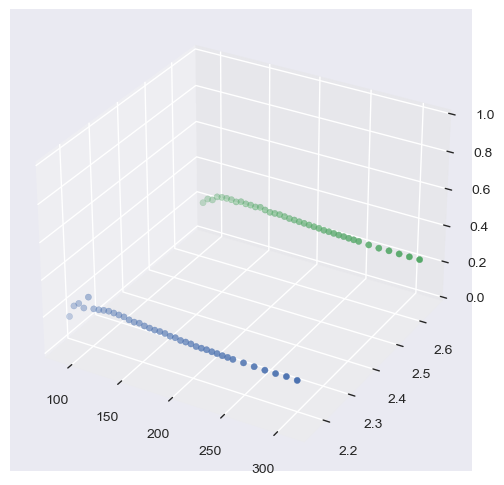

In [177]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for j in range(len(output)):
    calls = output[j][output[j]['option_type']=='call']
    ax.scatter(calls['strike'], calls['Maturity'], calls['Implied_Vol'])
ax.set_zlim(0,1)
plt.show()

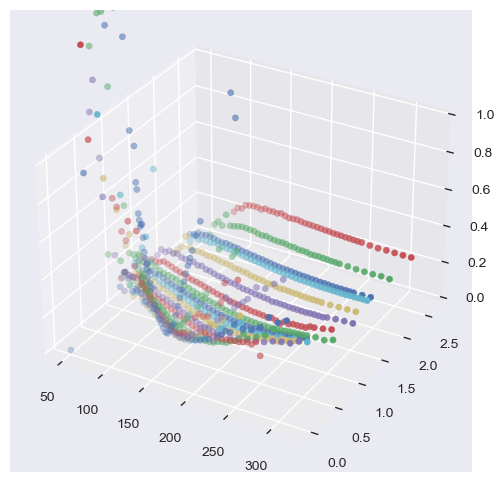

In [179]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(output)):
    for j in range(len(output[i])):
        calls = output[i][j][output[i][j]['option_type']=='call']
        ax.scatter(calls['strike'], calls['Maturity'], calls['Implied_Vol'])
ax.set_zlim(0,1)
plt.show()

In [ ]:
stock.options

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import CubicSpline
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import Rbf
from scipy.interpolate import CloughTocher2DInterpolator
from scipy.interpolate import LinearNDInterpolator
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
from scipy.interpolate import griddata
from scipy.interpolate import RectBivariateSpline, SmoothBivariateSpline, LSQBivariateSpline
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from matplotlib.lines import Line2D

def Interpolate_ImpliedVol(df, current_price=166):
    strike = np.array(df['strike'])
    volatility = np.array(df['Implied_Vol'])
    cs = UnivariateSpline(strike, volatility, s=0)
    #lower_bound = int(strike[0])
    #upper_bound = int(strike[-1])
    lower_bound = int(current_price*0.9)
    upper_bound = int(current_price*1.1)
    interpolated_strike = np.linspace(lower_bound, upper_bound, upper_bound-lower_bound+1)
    interpolated_volatility = cs(interpolated_strike)
    return interpolated_strike, interpolated_volatility

def Non_Nan(arr):
    is_nan = np.isnan(arr)
    return arr[~is_nan]

ticker='AAPL'
current_price = 166

stock = yf.Ticker(ticker)
len_date = len(stock.options)
lower_bound = int(current_price*0.9)
upper_bound = int(current_price*1.1)
matrix_size = upper_bound - lower_bound + 1
date_step = matrix_size // len_date
grid_matrix = np.full((matrix_size, matrix_size), np.nan)
X = []
y = []
for i in range(0, len(output)):
    for j in range(len(output[i])):
        temp = output[i][j][output[i][j]['Implied_Vol'] != 0]
        calls = temp[temp['option_type']=='call']
        puts = temp[temp['option_type']=='put']
        calls = calls.dropna(subset=['Implied_Vol'])
        calls_list = list(zip(calls['Maturity'].values.tolist(), 
                              calls['strike'].values.tolist()))
        calls_list = [list(item) for item in calls_list]
        imps_list = calls['Implied_Vol'].values.tolist()
        X += calls_list
        y += imps_list

X = np.array(X)
expiry_dates, strike_prices= zip(*X)

model = make_pipeline(PolynomialFeatures(4), Ridge(alpha=0.3))
model.fit(X, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, c='b', marker='o', label='Original data')

x0_range = np.linspace(X[:, 0].min(), X[:, 0].max(), num=100)
x1_range = np.linspace(X[:, 1].min(), X[:, 1].max(), num=100)
x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)

X_grid = np.hstack([x0_grid.reshape(-1, 1), x1_grid.reshape(-1, 1)])
y_grid_pred = model.predict(X_grid).reshape(x0_grid.shape)
surface = ax.plot_surface(x0_grid, x1_grid, y_grid_pred, color='r', alpha=0.5)

#ax.plot_surface(x0_grid, x1_grid, y_grid_pred, color='r', alpha=0.5, label='Fitted plane')
ax.set_xlabel('Days to Expiry')
ax.set_ylabel('Strike Price')
ax.set_zlabel('Implied Volatility')

original_data_proxy = Line2D([0], [0], linestyle='none', c='b', marker='o')
fitted_plane_proxy = Line2D([0], [0], linestyle='none', c='r', marker='o')
ax.legend([original_data_proxy, fitted_plane_proxy], ['Original data', 'Fitted plane'], numpoints=1)

#plt.legend()
plt.show()



In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

output_list = []
for i in range(0, len(output)):
    for j in range(len(output[i])):
        temp = output[i][j][output[i][j]['Implied_Vol'] != 0]
        calls = temp[temp['option_type']=='call']
        puts = temp[temp['option_type']=='put']
        output_data = list(zip(calls['Maturity'].values.tolist(), calls['strike'].values.tolist(),
                              calls['Implied_Vol'].values.tolist()))
        output_list += output_data


#data = [[x1, y1, z1], [x2, y2, z2], ...]

def prepare_features(x, y):
    return [x, y, x**0.5, y**2]

# 将数据分成输入（X）和输出（y）
X = [prepare_features(d[0], d[1]) for d in output_list]  # 使用 prepare_features 函数处理每个点的 x 和 y 值
y = [d[2] for d in output_list]   # 只保留 z 值

# 将 X 和 y 转换为 PyTorch 张量
X_train = torch.tensor(X, dtype=torch.float32)
y_train = torch.tensor(y, dtype=torch.float32)

class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# 创建数据集
train_dataset = MyDataset(X_train, y_train)

# 创建数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# 定义神经网络模型
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layer1 = nn.Linear(4, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# 实例化模型
model = RegressionModel()

# 定义损失函数和优化器
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练循环
num_epochs = 100
for epoch in range(num_epochs):
    for batch_X, batch_y in train_loader:
        # 清除梯度
        optimizer.zero_grad()

        # 前向传播
        predictions = model(batch_X)

        # 计算损失
        loss = loss_function(predictions.squeeze(), batch_y)

        # 反向传播
        loss.backward()

        # 更新参数
        optimizer.step()

    # 您可以在每个 epoch 结束时输出损失或其他指标
    print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")



## Test single vol

In [176]:
import math
ticker='AAPL'
stock = yf.Ticker(ticker)
stock_info = stock.info
current_stock_price = stock_info['regularMarketPrice']
date_lists = stock.options

option_data = stock.option_chain('2023-04-28')
call_data = option_data.calls
put_data = option_data.puts
options_data = pd.concat([call_data, put_data])
today = datetime.date.today()
options_data['Maturity'] = (datetime.datetime.strptime('2023-04-28',"%Y-%m-%d").date() - today).days/365
options_data['option_type'] = options_data['contractSymbol'].apply(lambda x:'call' if x[-9]=='C' else 'put')
        
def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, q=0.1, option_type="call", model="BS"):
    Indicator = lambda x: 1 if x=='call' else -1
    omega = Indicator(option_type)
    d1 = (np.log(S0/K)+(r-q+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = (np.log(S0/K)+(r-q-sigma**2/2)*T) / (sigma*np.sqrt(T))
    return S0*np.exp(-q*T)*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr_init=1, sigma_init=1, tol=0.00001):
    def error_function(sigma):
        return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, 
                                                   option_type=option_type) - market_price
    def vega(sigma):
        d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)

    def adjust_sigma(sigma, loss):
        Indicator = lambda x: 0.5 if x > 0 else 2
        indicator = Indicator(loss)
        return sigma * indicator

    sigma1 = sigma2 = sigma_init
    loss1 = loss2 = error_function(sigma1)
    lr = lr_init
    while np.abs(loss2) >= tol:
        print(sigma1)
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("error", category=RuntimeWarning)
                adjusted_value = lr * error_function(sigma1) / vega(sigma1)
                sigma2 = sigma1 - adjusted_value
                loss2 = error_function(sigma2)
                if loss1*loss2 > 0:
                    sigma1 = sigma2
                    loss1=loss2
                else:
                    if lr > 0.1:
                        lr = lr / 3
                    else:
                        sigma1 = adjust_sigma(sigma1, loss1)
        except ZeroDivisionError:
            sigma1 = adjust_sigma(sigma1, loss1)
            print('ZeroDivisionError, readjust sigma ', sigma1)
            loss2 = error_function(sigma1)
            lr=lr_init
        except FloatingPointError:
            sigma1 = adjust_sigma(sigma1, loss1)
            print('FloatingPointError, readjust sigma ', sigma1)
            loss2 = error_function(sigma1)
            lr=lr_init
        except RuntimeWarning:
            sigma1 = adjust_sigma(sigma1, loss1)
            print('RuntimeWarning, readjust sigma ', sigma1)
            loss2 = error_function(sigma1)
            lr=lr_init

    return sigma1

S0 = 163.77
K = 95
market_price = 78.6
T = 2.16
r = 0.0469
q = 0
sigma=1
opt='call'
t = time.time()
print(BlackScholes_Implied_Vol(S0=S0, K=K, T=T, q=q, r=r, sigma_init=sigma, market_price = market_price, option_type=opt))
print('the running time is {}'.format(time.time()-t))

1
0.3246396687769949
0.2664667271303849
0.25110659055498663
0.24969236612210943
0.24968009400786828
the running time is 0.00533294677734375


In [88]:
BlackScholes_ConditionalExpectation(S0=165.02, K=85, T=2.16, sigma=0.3538 , r=0.0469, q=0, option_type="call", model="BS")
#S0=165.02, K=185.0, T=0.0684931506849315, P=18.91
#market_price < (S-K)*np.exp(T*r)

89.99873387360049

In [24]:
165 - 85*np.exp(-0.046*2)

87.47106228866731

In [174]:
stock = yf.Ticker('AAPL')
stock_info = stock.info
stock_info['regularMarketPrice']

163.77

In [ ]:
def newton_method(f, f_prime, x0, max_iter=100, tol=1e-6, attempt=0, max_attempts=3):
    x = x0
    for i in range(max_iter):
        try:
            x_new = x - f(x) / f_prime(x)
        except ZeroDivisionError:
            print("Error: Division by zero encountered.")
            if attempt < max_attempts:
                print("Retrying with a slightly perturbed initial guess.")
                return newton_method(f, f_prime, x0 + 1e-5, max_iter, tol, attempt + 1, max_attempts)
            else:
                print(f"Maximum number of attempts ({max_attempts}) reached. Stopping iteration.")
                return None

        if abs(x_new - x) < tol:
            return x_new
        x = x_new

    print("Warning: Maximum number of iterations reached. Solution may not have converged.")
    return x


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split  # 导入 train_test_split 函数


# 假设 input_data 和 output_data 是已经准备好的 NumPy 数组
# input_data = ...
# output_data = ...
input_list = []
output_list = []
for i in range(0, len(output)):
    for j in range(len(output[i])):
        temp = output[i][j][output[i][j]['Implied_Vol'] != 0]
        calls = temp[temp['option_type']=='call']
        puts = temp[temp['option_type']=='put']
        in_list = list(zip(calls['Maturity'].values.tolist(), np.sqrt(calls['Maturity'].values).tolist(),
                              calls['strike'].values.tolist(), (calls['strike'].values**2).tolist()))
        out_list = list(calls['Implied_Vol'].values.tolist())
        input_list += in_list
        output_list += out_list
        
        
input_train_np, input_test_np, output_train_np, output_test_np = train_test_split(input_list, output_list, test_size=0.2, random_state=42)

# 转换 NumPy 数组为 PyTorch 张量
input_train = torch.tensor(input_train_np, dtype=torch.float32)
input_test = torch.tensor(input_test_np, dtype=torch.float32)
output_train = torch.tensor(output_train_np, dtype=torch.float32)
output_test = torch.tensor(output_test_np, dtype=torch.float32)

# 定义一个简单的全连接神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = Net()

# 定义损失函数和优化器
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
#optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, weight_decay=1e-5)
#optimizer = optim.Adagrad(model.parameters(), lr=0.01, weight_decay=1e-5)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 训练模型
num_epochs = 10000
for epoch in range(num_epochs):
    # 前向传播
    predictions = model(input_train)
    loss = criterion(predictions, output_train)

    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 打印损失
    if (epoch + 1) % 500 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}")

# 评估模型
model.eval()
with torch.no_grad():
    test_predictions = model(input_test)
    test_loss = criterion(test_predictions, output_test)
    print(f"Test Loss: {test_loss.item()}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 创建 X 和 Y 的网格
x_range = np.linspace(x_min, x_max, 100)  # 请将 x_min 和 x_max 替换为实际数据范围
y_range = np.linspace(y_min, y_max, 100)  # 请将 y_min 和 y_max 替换为实际数据范围
x_grid, y_grid = np.meshgrid(x_range, y_range)

# 为网格中的每个点计算相应的输入特征
input_features = np.array([prepare_features(x, y) for x, y in zip(np.ravel(x_grid), np.ravel(y_grid))])

# 使用模型预测 Z 值
with torch.no_grad():
    z_grid = model(torch.tensor(input_features, dtype=torch.float32)).numpy().reshape(x_grid.shape)

# 创建 3D 图
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制表面
ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')

# 设置坐标轴标签
ax.set_xlabel('X (Original)')
ax.set_ylabel('Y (Original)')
ax.set_zlabel('Z')

# 显示图形
plt.show()




## Surface

In [ ]:
import inspect
from mpl_toolkits.mplot3d import Axes3D

def ImpliedVol_Analyser(func):
    def wrapper(*args, **kwargs):
        def split_array(array, num_parts):
            result = []
            size_per_part = len(array) // num_parts
            remainder = len(array) % num_parts
            start = 0
            for i in range(num_parts):
                end = start + size_per_part
                if i < remainder:
                    end += 1
                result.append(array[start:end])
                start = end
            return result
        
        def split_array_df(array, num_parts):
            result = []
            size_per_part = len(array) // num_parts
            remainder = len(array) % num_parts
            start = 0
            for i in range(num_parts):
                end = start + size_per_part
                if i < remainder:
                    end += 1
                result.append(array[start:end])
                start = end
            return result
        
        sig = inspect.signature(func)
        bound_arguments = sig.bind_partial(*args, **kwargs)
        bound_arguments.apply_defaults()
        ticker = bound_arguments.arguments.get('ticker')
        
        stock = yf.Ticker(ticker)
        stock_info = stock.info
        current_stock_price = stock_info['regularMarketPrice']
        date_lists = stock.options
        
        options_data = []
        for date in date_lists:
            option_data = stock.option_chain(date)
            call_data = option_data.calls
            put_data = option_data.puts
            options_data.append(pd.concat([call_data, put_data]))
        
        cores = 8
        date_lists = split_array(array = date_lists, num_parts=cores)
        option_lists = split_array_df(array = options_data, num_parts=cores)
        
        opt_dict = {'call':0, 'put':1}
        
        output = np.array(Parallel(n_jobs=cores)(delayed(func)(ticker=ticker, options_data=option_lists[i],
                                                               date_list=date_lists[i]), current_price=current_stock_price
                                                                 for i in range(cores)))
        plt.style.use('default')
        plt.style.use('seaborn')
        fig, axs = plt.subplots(2, 1, figsize=(10, 10))
        axs = [None]*2
        
        res = []
        for i in range(cores):
            res += output[i]
        for opt in ('call', 'put'):  
            axs[opt_dict[opt]] = fig.add_subplot(2, 1, 1, projection='3d')
            #axs[opt_dict[opt]] = plt.add_subplot(2,1, opt_dict[opt] + 1, projection='3d')
            for i in range(len(res)):
                vols = res[i][res[i]['option_type']==opt]
                axs[opt_dict[opt]].scatter(vols['strike'], vols['Maturity'], vols['Implied_Vol'])
                axs[opt_dict[opt]].plot(vols['strike'], vols['Maturity'], vols['Implied_Vol'])
            axs[opt_dict[opt]].set_xlabel('Spot Price')
            axs[opt_dict[opt]].set_ylabel('Time to maturity - Years')
            axs[opt_dict[opt]].set_zlabel('Implied Volatility')
            axs[opt_dict[opt]].set_zlim(0,1)

        plt.tight_layout()
        plt.show()
            
        return res
    return wrapper

In [ ]:
ticker = 'AAPL'
date_list = yf.Ticker(ticker).options

In [ ]:
from scipy.stats import norm

def ImpliedVolatilitySurface(date_list, options_data=[], ticker='AAPL', current_price=100, lr=0.001, 
                            sigma_init=1):
    def BlackScholes_ConditionalExpectation(S0=100, K=100, T=1, sigma=0.2, r=0.1, q=0.1, option_type="call", model="BS"):
        Indicator = lambda x: 1 if x=='call' else -1
        omega = Indicator(option_type)
        d1 = (np.log(S0/K)+(r-q+sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = (np.log(S0/K)+(r-q-sigma**2/2)*T) / (sigma*np.sqrt(T))
        return S0*np.exp(-q*T)*omega*stats.norm.cdf(d1*omega) - K*omega*np.exp(-r*T)*stats.norm.cdf(d2*omega)

    def get_risk_free_rate():
        fred_api_key = '2e70718a1fe20b843dc88972ac57f907'
        fred = Fred(api_key=fred_api_key)
        return fred.get_series('TB3MS')[-1] / 100

    def BlackScholes_Implied_Vol(S0, K, T, r, q, market_price, option_type, lr=1, sigma_init=sigma_init, tol=0.0001):
        if S0 > K + market_price:
            return np.nan
        def error_function(sigma):
            return BlackScholes_ConditionalExpectation(S0=S0, K=K, T=T, r=r, q=q, sigma=sigma, 
                                                       option_type=option_type) - market_price
        def vega(sigma):
            d1 = (np.log(S0 / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
            return  S0 * np.exp(-q*T) * np.sqrt(T) * norm.pdf(d1)

        sigma1 = sigma_init
        loss1 = loss2 = error_function(sigma1)
        while np.abs(loss2) >= tol > 0:
            loss1 = loss2
            try:
                sigma2 = sigma1 - lr * error_function(sigma1) / vega(sigma1)
            except OverflowError or ZeroDivisionError:
                if loss1 > 0:
                    sigma1 = sigma1 / 2
                elif loss1 < 0:
                    sigma1 = sigma1 * 2
                print("Error: Overflow encountered in calculation. Readjust the sigma {}".format(sigma1))
                return BlackScholes_Implied_Vol(S0=S0, K=K, T=T, r=r, q=q, market_price=market_price,
                                           option_type=option_type, lr=lr, sigma_init=sigma1, 
                                           tol=0.0001)

            loss2 = error_function(sigma2)
            if loss2*loss1>0:
                sigma1 = sigma2
            
            else:
                lr = lr / 10
                if lr < 0.0000000000001:
                    return sigma1
                return BlackScholes_Implied_Vol(S0=S0, K=K, T=T, r=r, q=q, market_price=market_price,
                                           option_type=option_type, lr=lr, sigma_init=sigma1, 
                                           tol=0.0001)
            
        return sigma1

    BlackScholes_Implied_Vol = np.vectorize(BlackScholes_Implied_Vol)

    current_stock_price = current_price
    today = datetime.date.today()
    risk_free_rate = get_risk_free_rate()

    options = []

    for i in range(len(date_list)):
        options_data[i]['Maturity'] = (datetime.datetime.strptime(date_list[i],"%Y-%m-%d").date() - today).days/365
        options_data[i]['option_type'] = options_data[i]['contractSymbol'].apply(lambda x:'call' if x[-9]=='C' else 'put')
        options_data[i]['Implied_Vol'] = BlackScholes_Implied_Vol(S0 = current_stock_price, K = options_data[i]['strike'],
                                                            T = options_data[i]['Maturity'], r = risk_free_rate, q=0.02,  
                                                            market_price = options_data[i]['lastPrice'], 
                                                            option_type = options_data[i]['option_type'], tol = 0.0001)
        options_data[i].loc[(options_data[i]['Implied_Vol'] > 5) | (options_data[i]['Implied_Vol'] < -5), 'Implied_Vol'] = 0
        options.append(options_data[i])

    return options

#ticker = 'AAPL'
#date_list = yf.Ticker(ticker).options
#res = ImpliedVolatilitySurface(date_list, ticker='AAPL')


In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(options)):
    
    calls = options[i][options[i]['option_type']=='call']
    ax.scatter(calls['strike'], calls['Maturity'], calls['Implied_Vol'])

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d
x = np.linspace(-2, 2, 10)
y = np.linspace(-2, 2, 10)
x, y = np.meshgrid(x, y)

z = x**2 + y**2
print(z)
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

ax.plot_wireframe(x,y,z, rstride=5, cstride=5, alpha=0.7, linewidth=0.8)

plt.show()

In [ ]:
import time

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time:.4f} seconds")
        return result
    return wrapper

# Use the decorator on another function
@timing_decorator
def slow_function(seconds):
    time.sleep(seconds)
    return f"Finished sleeping for {seconds} seconds"

# Call the decorated function
result = slow_function(3)
print(result)

In [ ]:
import sys
import numpy as np
from PyQt5.QtWidgets import QApplication, QMainWindow, QVBoxLayout, QWidget
from PyQt5.QtCore import QTimer
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg as FigureCanvas
from matplotlib.figure import Figure


class BrownianMotionPlot(FigureCanvas):
    def __init__(self, parent=None, width=5, height=4, dpi=100):
        self.fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = self.fig.add_subplot(111)
        super().__init__(self.fig)

        self.x1 = [100]
        self.x2 = [100]
        self.time = 0
        self.dt = 1.0
        self.mu = 0.01
        self.sigma = 0.4

        self.animate()

    def exponential_brownian_motion_step(self):
        dw1 = np.random.normal(0, np.sqrt(self.dt))
        dw2 = np.random.normal(0, np.sqrt(self.dt))
        dx1 = self.mu * self.x1[-1] * self.dt + self.sigma * self.x1[-1] * dw1
        dx2 = self.mu * self.x2[-1] * self.dt + self.sigma * self.x2[-1] * dw2
        self.x1.append(self.x1[-1] + dx1)
        self.x2.append(self.x2[-1] + dx2)
        self.time += 1

    def animate(self):
        self.exponential_brownian_motion_step()
        self.axes.clear()
        self.axes.plot(self.x1, label="Exponential Brownian Motion 1")
        self.axes.plot(self.x2, label="Exponential Brownian Motion 2")
        self.axes.set_xlabel("Time")
        self.axes.set_ylabel("Price")
        self.axes.legend()
        self.axes.set_xlim(0, self.time)  # Update x-axis limits
        self.draw()



class MainWindow(QMainWindow):
    def __init__(self):
        super().__init__()

        self.setWindowTitle("2D Exponential Brownian Motion Animation")
        self.setGeometry(100, 100, 800, 600)

        widget = QWidget(self)
        self.setCentralWidget(widget)

        layout = QVBoxLayout()
        widget.setLayout(layout)

        self.plot = BrownianMotionPlot()
        layout.addWidget(self.plot)

        self.timer = QTimer()
        self.timer.setInterval(100)  # 100 ms
        self.timer.timeout.connect(self.update_plot)
        self.timer.start()

    def update_plot(self):
        self.plot.animate()


if __name__ == "__main__":
    app = QApplication(sys.argv)
    window = MainWindow()
    window.show()
    sys.exit(app.exec_())
